## Capstone - Sales Forecasting

### Problem Statement

Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann, an European drug distributor to accurately forecast sales at their individual stores. The task is to build a forecasting model to forecast the daily sales for the next six weeks for Rossmann

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Reading train dataset
train = pd.read_csv('train.csv')
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [3]:
# Checking info on train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
# Converting the Date column to datetime
train['Date'] = pd.to_datetime(train['Date'], format = '%Y-%m-%d')

In [5]:
# Checking train dataset
train.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [6]:
# Extracting year, month, day & week of year from Date
train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Day'] = train.Date.dt.day
train['WeekOfYear'] = train.Date.dt.weekofyear

In [7]:
# Checking train dataset
train.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  Year  Month  Day  WeekOfYear  
0              1  2015      7   31          31  
1              1  2015      7   31          31  
2              1  2015      7   31          31  
3              1  2015      7   31          31  
4              1  2015      7   31          31

In [8]:
# Checking info on train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   Year           1017209 non-null  int64         
 10  Month          1017209 non-null  int64         
 11  Day            1017209 non-null  int64         
 12  WeekOfYear     1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(11), object(1)
memory usage: 100.9+ MB


In [9]:
# Checking describe on Sales
train['Sales'].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

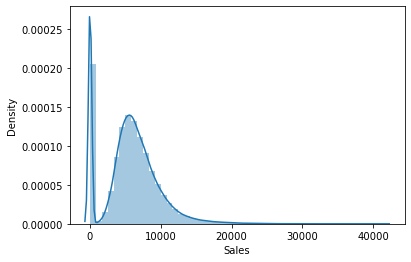

In [10]:
# Checking distribtuion plot of Sales 
sns.distplot(train['Sales'])
plt.show()

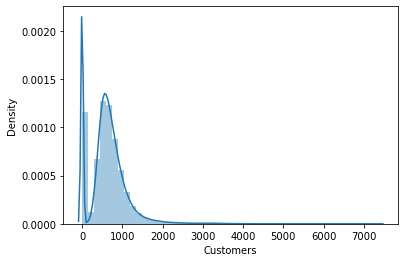

In [11]:
# Checking distribtuion plot of Customers 
sns.distplot(train['Customers'])
plt.show()

In [12]:
# Checking shape of train
train.shape

(1017209, 13)

In [13]:
# Replacing zero values of Sales with 1 so that it is easy for log transformation
train['Sales'] = train['Sales'].apply(lambda x : 1 if x <= 1 else x)

In [14]:
# Checking describe of Sales data
train['Sales'].describe()

count    1.017209e+06
mean     5.773989e+03
std      3.849671e+03
min      1.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

In [15]:
# Reading store dataset
store = pd.read_csv('store.csv')
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [16]:
# No of unique stores in train dataset
train['Store'].nunique()

1115

In [17]:
# Shape of store dataset
store.shape

(1115, 10)

In [18]:
# Checking info on store dataset
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [19]:
# Checking describe on CompetitionDistance
store['CompetitionDistance'].describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

In [20]:
# Filling null values of CompetitionDistance with median value
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].quantile(0.5))

In [21]:
# Checking info on store dataset
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [22]:
# Filling other null values with value 0
store = store.fillna(0)

In [23]:
# Checking info on store dataset
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [24]:
# Merging both the dataset
train_store = pd.merge(train, store, on = 'Store', how = 'inner')

In [25]:
train_store = train_store.set_index('Date')
train_store.index.freq = train_store.index.inferred_freq

In [26]:
# Checking the train_store dataset
train_store.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-30      1          4   5020        546     1      1            0   
2015-07-29      1          3   4782        523     1      1            0   
2015-07-28      1          2   5011        560     1      1            0   
2015-07-27      1          1   6102        612     1      1            0   

            SchoolHoliday  Year  Month  ...  WeekOfYear  StoreType Assortment  \
Date                                    ...                                     
2015-07-31              1  2015      7  ...          31          c          a   
2015-07-30              1  2015      7  ...          31          c          a   
2015-07-29              1  2015      7  ...          31          c          a   
2015-07-28              1  2015      7  ...          31          c          a   
2015-07-27              1  2015      7  ...          31          c          a   

           CompetitionDistance  CompetitionOpenSinceMonth  \
Date                                                        
2015-07-31              1270.0                        9.0   
2015-07-30              1270.0                        9.0   
2015-07-29              1270.0                        9.0   
2015-07-28              1270.0                        9.0   
2015-07-27              1270.0                        9.0   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
Date                                                            
2015-07-31                    2008.0       0              0.0   
2015-07-30                    2008.0       0              0.0   
2015-07-29                    2008.0       0              0.0   
2015-07-28                    2008.0       0              0.0   
2015-07-27                    2008.0       0              0.0   

            Promo2SinceYear  PromoInterval  
Date                                        
2015-07-31              0.0              0  
2015-07-30              0.0              0  
2015-07-29              0.0              0  
2015-07-28              0.0              0  
2015-07-27              0.0              0  

[5 rows x 21 columns]

In [27]:
# Checking shape of train_store dataset
train_store.shape

(1017209, 21)

#### Exploratory Data Analysis

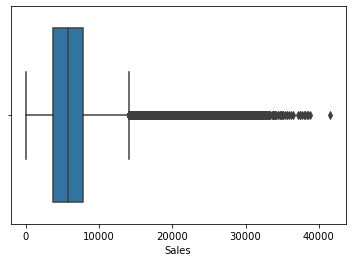

In [28]:
# Checking boxplot for Sales
sns.boxplot(train_store['Sales'])
plt.show()

In [29]:
# Checking describe of Sales
train_store['Sales'].quantile(0.99)

17160.0

In [30]:
# Capping the values to 99 percentile of Sales
train_store['Sales'] = train_store['Sales'].apply(lambda x : 17160 if x > 17160 else x)

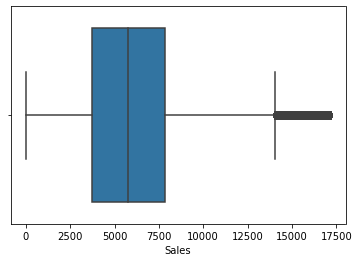

In [31]:
# Checking boxplot for Sales
sns.boxplot(train_store['Sales'])
plt.show()

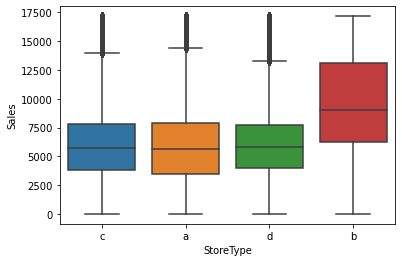

In [32]:
# Checking Sales as per Storetype
sns.boxplot(train_store['StoreType'], train_store['Sales'])
plt.show()

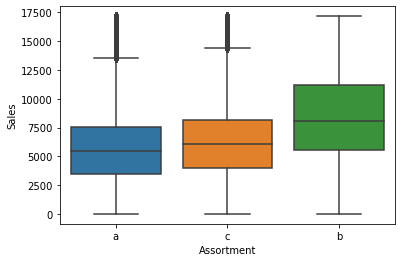

In [33]:
# Checking Sales as per Assortment
sns.boxplot(train_store['Assortment'], train_store['Sales'])
plt.show()

In [34]:
# Checking info on train_store
train_store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   Year                       1017209 non-null  int64  
 9   Month                      1017209 non-null  int64  
 10  Day                        1017209 non-null  int64  
 11  WeekOfYear                 1017209 non-null  int64  
 12  StoreType                  1017209 non-null  object 
 1

In [35]:
# Converting Sales column to float
train_store['Sales'] = train_store['Sales'] * 1.0

In [36]:
# Checking dtype of Sales
train_store['Sales'].dtype

dtype('float64')

In [37]:
# Checking train_store dataset
train_store.head()

Store  DayOfWeek   Sales  Customers  Open  Promo StateHoliday  \
Date                                                                        
2015-07-31      1          5  5263.0        555     1      1            0   
2015-07-30      1          4  5020.0        546     1      1            0   
2015-07-29      1          3  4782.0        523     1      1            0   
2015-07-28      1          2  5011.0        560     1      1            0   
2015-07-27      1          1  6102.0        612     1      1            0   

            SchoolHoliday  Year  Month  ...  WeekOfYear  StoreType Assortment  \
Date                                    ...                                     
2015-07-31              1  2015      7  ...          31          c          a   
2015-07-30              1  2015      7  ...          31          c          a   
2015-07-29              1  2015      7  ...          31          c          a   
2015-07-28              1  2015      7  ...          31          c          a   
2015-07-27              1  2015      7  ...          31          c          a   

           CompetitionDistance  CompetitionOpenSinceMonth  \
Date                                                        
2015-07-31              1270.0                        9.0   
2015-07-30              1270.0                        9.0   
2015-07-29              1270.0                        9.0   
2015-07-28              1270.0                        9.0   
2015-07-27              1270.0                        9.0   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
Date                                                            
2015-07-31                    2008.0       0              0.0   
2015-07-30                    2008.0       0              0.0   
2015-07-29                    2008.0       0              0.0   
2015-07-28                    2008.0       0              0.0   
2015-07-27                    2008.0       0              0.0   

            Promo2SinceYear  PromoInterval  
Date                                        
2015-07-31              0.0              0  
2015-07-30              0.0              0  
2015-07-29              0.0              0  
2015-07-28              0.0              0  
2015-07-27              0.0              0  

[5 rows x 21 columns]

#### Time Series Analysis

In [38]:
# Taking sales data of historic stores (1,3,8,9,13,25,29,31 and 46)
store_1_sales = train[train.Store == 1]
store_3_sales = train[train.Store == 3]
store_8_sales = train[train.Store == 8]
store_9_sales = train[train.Store == 9]
store_13_sales = train[train.Store == 13]
store_25_sales = train[train.Store == 25]
store_29_sales = train[train.Store == 29]
store_31_sales = train[train.Store == 31]
store_46_sales = train[train.Store == 46]

In [39]:
# Setting index as Date
store_1_sales = store_1_sales.set_index('Date').sort_index(ascending = True)
store_1_sales.index.freq = store_1_sales.index.inferred_freq
store_3_sales = store_3_sales.set_index('Date').sort_index(ascending = True)
store_3_sales.index.freq = store_3_sales.index.inferred_freq
store_8_sales = store_8_sales.set_index('Date').sort_index(ascending = True)
store_8_sales.index.freq = store_8_sales.index.inferred_freq
store_9_sales = store_9_sales.set_index('Date').sort_index(ascending = True)
store_9_sales.index.freq = store_9_sales.index.inferred_freq
store_13_sales = store_13_sales.set_index('Date').sort_index(ascending = True)
store_13_sales = store_13_sales.index.inferred_freq
store_25_sales = store_25_sales.set_index('Date').sort_index(ascending = True)
store_25_sales.index.freq = store_25_sales.index.inferred_freq
store_29_sales = store_29_sales.set_index('Date').sort_index(ascending = True)
store_29_sales.index.freq = store_29_sales.index.inferred_freq
store_31_sales = store_31_sales.set_index('Date').sort_index(ascending = True)
store_31_sales.index.freq = store_31_sales.index.inferred_freq
store_46_sales = store_46_sales.set_index('Date').sort_index(ascending = True)
store_46_sales.index.freq = store_46_sales.index.inferred_freq

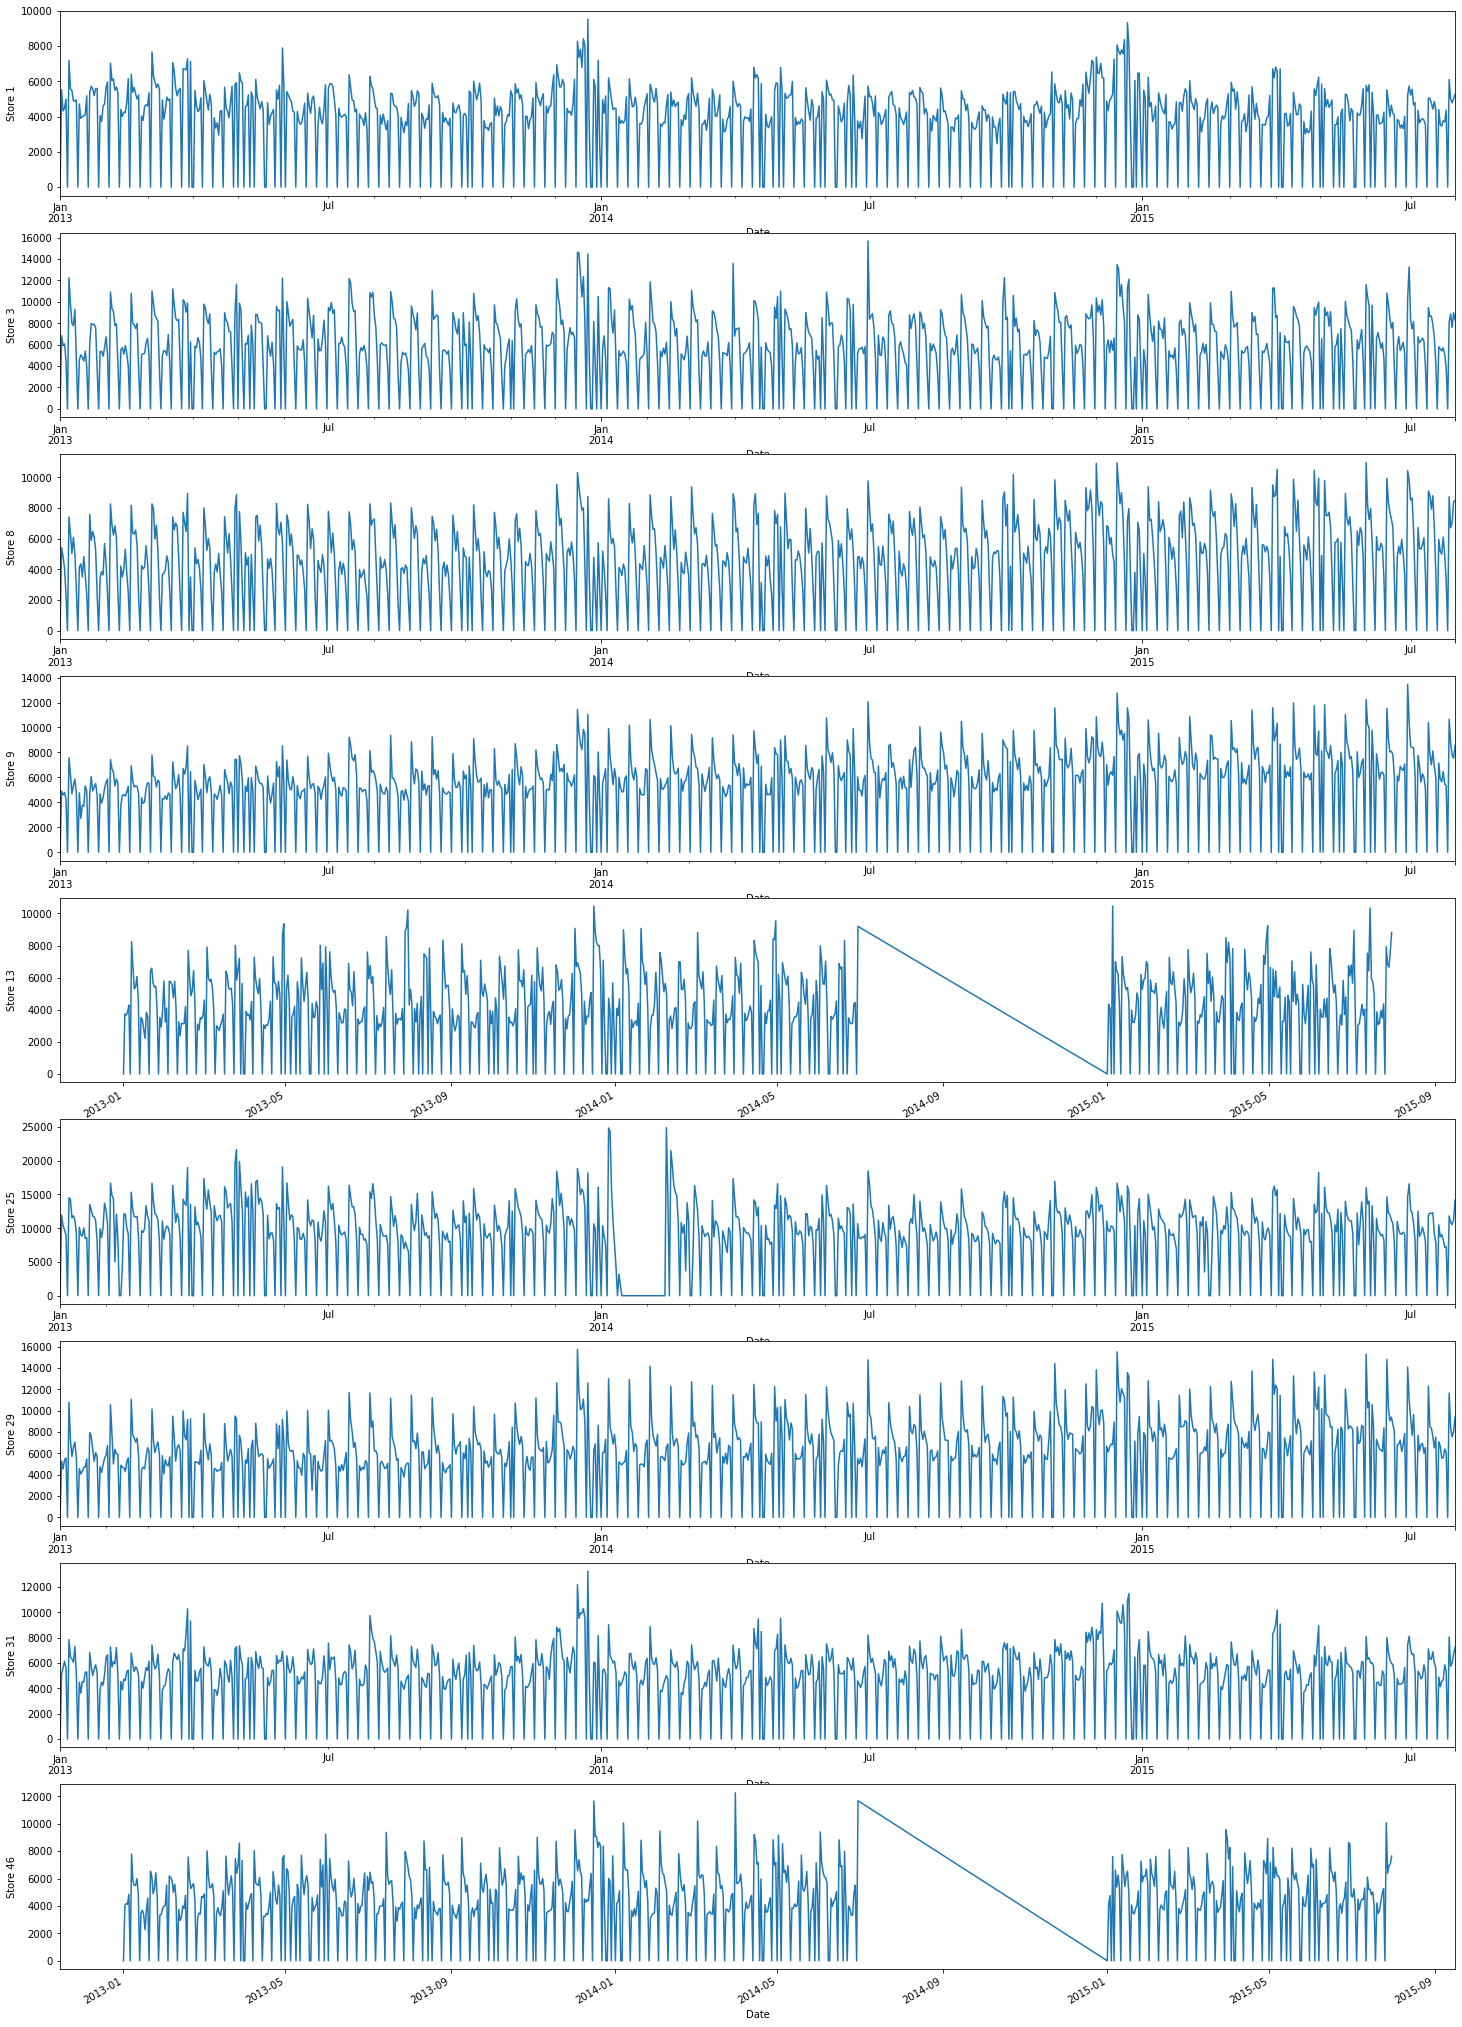

In [40]:
# Plotting Sales for store types selected
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize = (25, 40))
store_1_sales.Sales.plot(ax = ax1)
ax1.set_ylabel('Store 1')

store_3_sales.Sales.plot(ax = ax2)
ax2.set_ylabel('Store 3')

store_8_sales.Sales.plot(ax = ax3)
ax3.set_ylabel('Store 8')

store_9_sales.Sales.plot(ax = ax4)
ax4.set_ylabel('Store 9')

store_13_sales.Sales.plot(ax = ax5)
ax5.set_ylabel('Store 13')

store_25_sales.Sales.plot(ax = ax6)
ax6.set_ylabel('Store 25')

store_29_sales.Sales.plot(ax = ax7)
ax7.set_ylabel('Store 29')

store_31_sales.Sales.plot(ax = ax8)
ax8.set_ylabel('Store 31')

store_46_sales.Sales.plot(ax = ax9)
ax9.set_ylabel('Store 46')

plt.show()

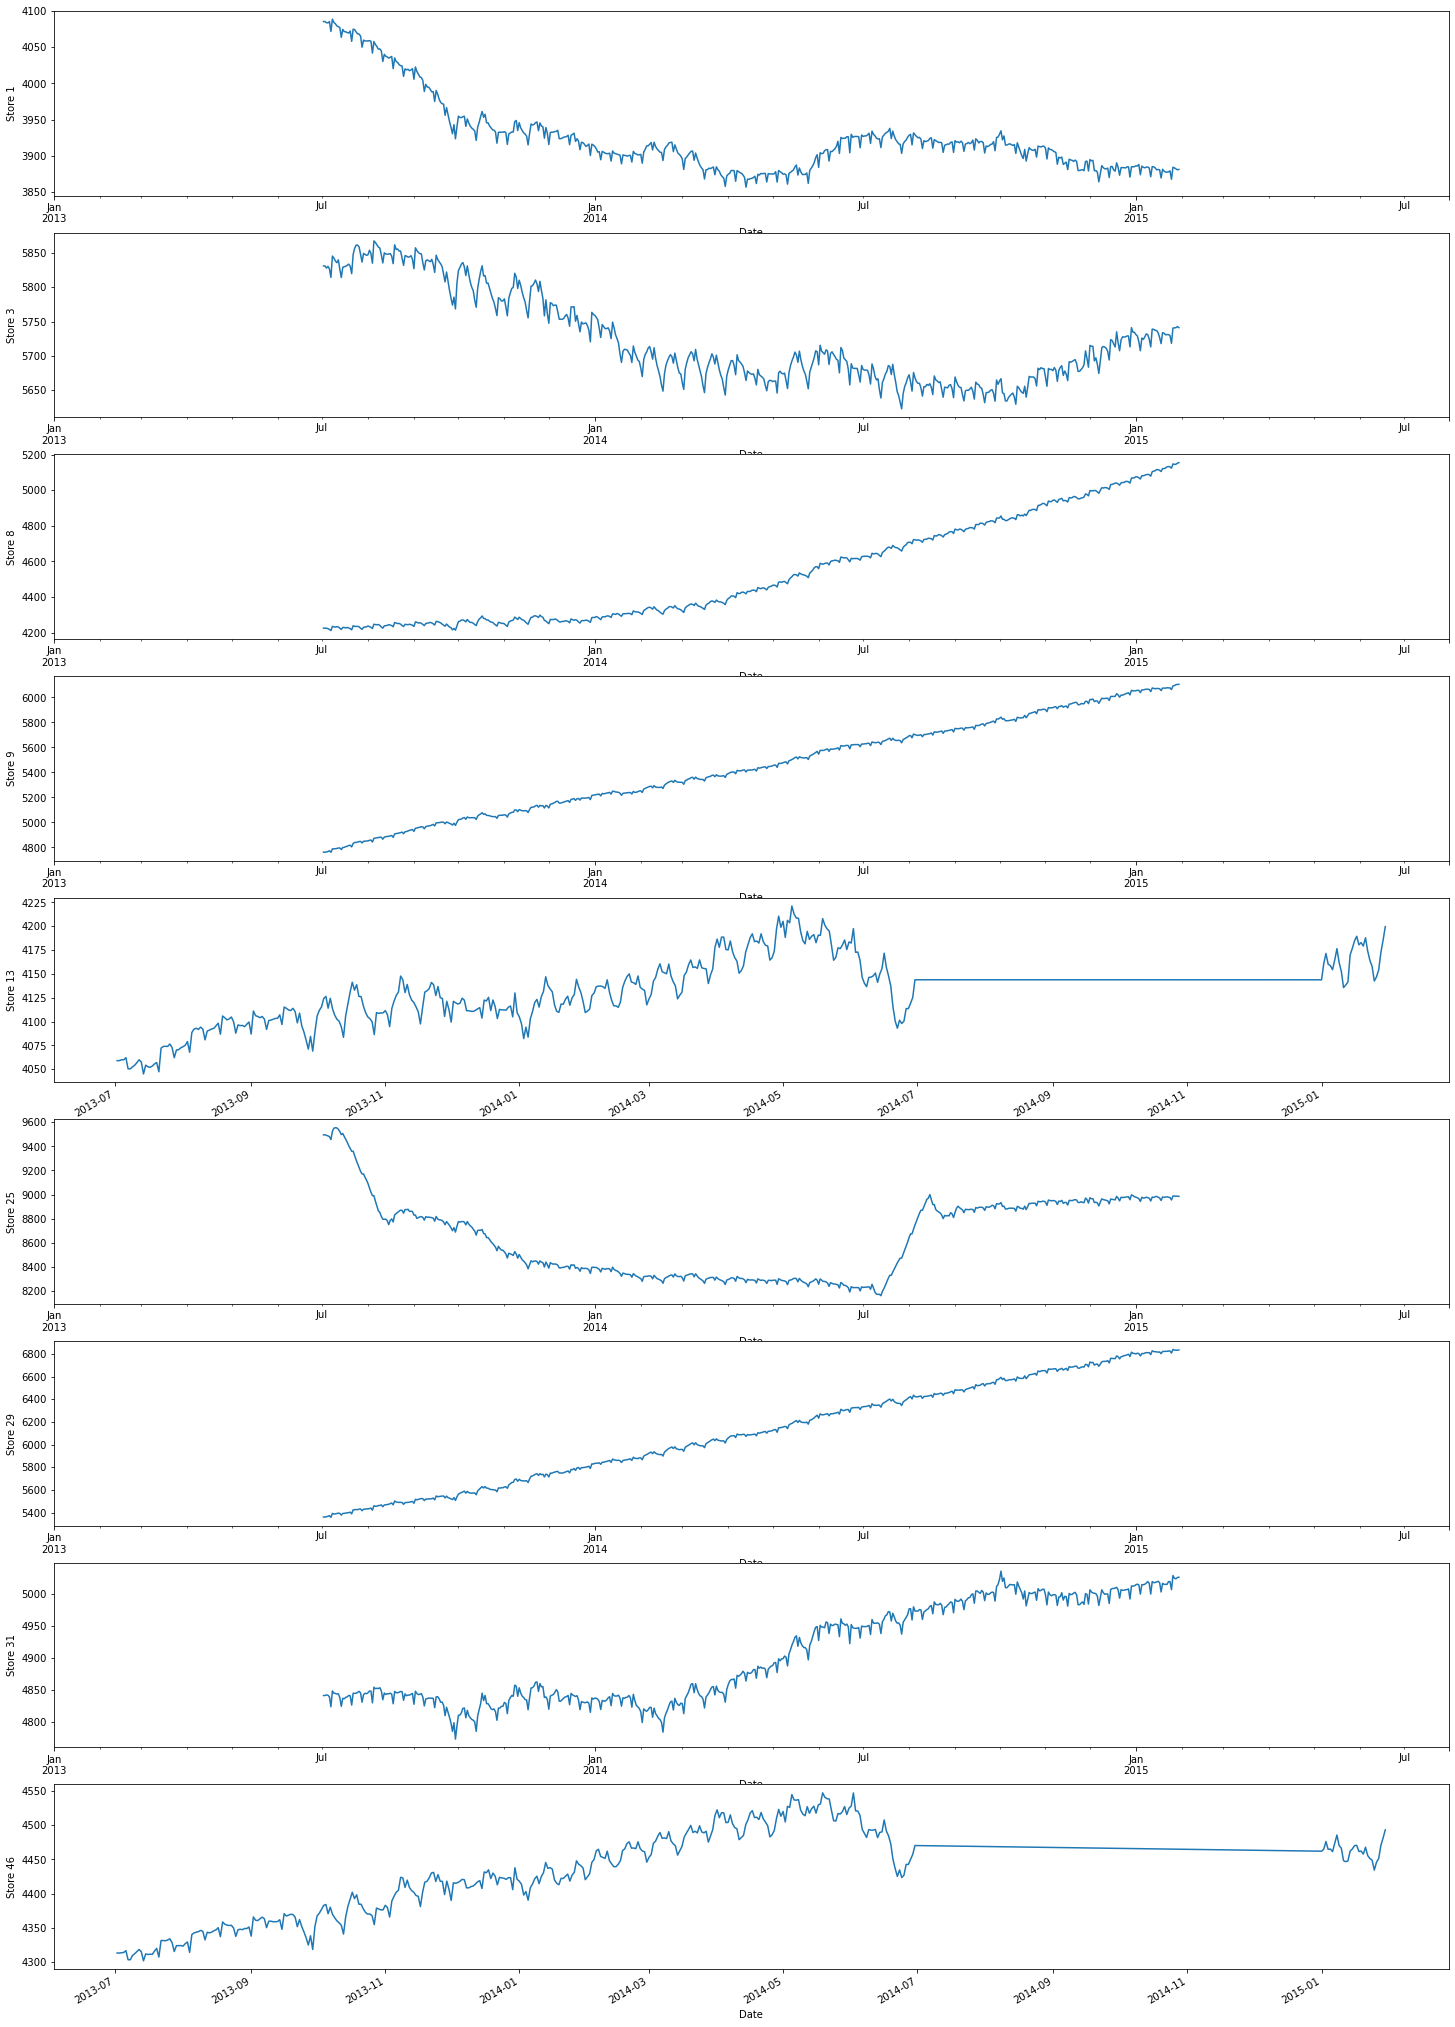

In [41]:
# Checking seasonality in all the stores
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize = (25, 40))
store_1_decomposed = seasonal_decompose(store_1_sales.Sales, model = 'additive', freq = 365)
store_1_decomposed.trend.plot(ax = ax1)
ax1.set_ylabel('Store 1')
store_3_decomposed = seasonal_decompose(store_3_sales.Sales, model = 'additive', freq = 365)
store_3_decomposed.trend.plot(ax = ax2)
ax2.set_ylabel('Store 3')
store_8_decomposed = seasonal_decompose(store_8_sales.Sales, model = 'additive', freq = 365)
store_8_decomposed.trend.plot(ax = ax3)
ax3.set_ylabel('Store 8')
store_9_decomposed = sm.tsa.seasonal_decompose(store_9_sales.Sales, model = 'additive', freq = 365)
store_9_decomposed.trend.plot(ax = ax4)
ax4.set_ylabel('Store 9')
store_13_decomposed = sm.tsa.seasonal_decompose(store_13_sales.Sales, model = 'additive', freq = 365)
store_13_decomposed.trend.plot(ax = ax5)
ax5.set_ylabel('Store 13')
store_25_decomposed = sm.tsa.seasonal_decompose(store_25_sales.Sales, model = 'additive', freq = 365)
store_25_decomposed.trend.plot(ax = ax6)
ax6.set_ylabel('Store 25')
store_29_decomposed = sm.tsa.seasonal_decompose(store_29_sales.Sales, model = 'additive', freq = 365)
store_29_decomposed.trend.plot(ax = ax7)
ax7.set_ylabel('Store 29')
store_31_decomposed = sm.tsa.seasonal_decompose(store_31_sales.Sales, model = 'additive', freq = 365)
store_31_decomposed.trend.plot(ax = ax8)
ax8.set_ylabel('Store 31')
store_46_decomposed = sm.tsa.seasonal_decompose(store_46_sales.Sales, model = 'additive', freq = 365)
store_46_decomposed.trend.plot(ax = ax9)
ax9.set_ylabel('Store 46')
plt.show()

In [42]:
# Converting the sales value to float data type
store_1_sales['Sales'] = store_1_sales['Sales'] * 1.0
store_3_sales['Sales'] = store_3_sales['Sales'] * 1.0
store_8_sales['Sales'] = store_8_sales['Sales'] * 1.0
store_9_sales['Sales'] = store_9_sales['Sales'] * 1.0
store_13_sales['Sales'] = store_13_sales['Sales'] * 1.0
store_25_sales['Sales'] = store_25_sales['Sales'] * 1.0
store_29_sales['Sales'] = store_29_sales['Sales'] * 1.0
store_31_sales['Sales'] = store_31_sales['Sales'] * 1.0
store_46_sales['Sales'] = store_46_sales['Sales'] * 1.0

In [43]:
# Applying log transformation to sales data
store_1_sales['Log_Sales'] = np.log(store_1_sales['Sales'])
store_3_sales['Log_Sales'] = np.log(store_3_sales['Sales'])
store_8_sales['Log_Sales'] = np.log(store_8_sales['Sales'])
store_9_sales['Log_Sales'] = np.log(store_9_sales['Sales'])
store_13_sales['Log_Sales'] = np.log(store_13_sales['Sales'])
store_25_sales['Log_Sales'] = np.log(store_25_sales['Sales'])
store_29_sales['Log_Sales'] = np.log(store_29_sales['Sales'])
store_31_sales['Log_Sales'] = np.log(store_31_sales['Sales'])
store_46_sales['Log_Sales'] = np.log(store_46_sales['Sales'])

In [44]:
# Applying log transformation to Customers data
store_1_sales['Customers'] = store_1_sales['Customers'].apply(lambda x : 0 if x <= 0 else np.log(x))
store_3_sales['Customers'] = store_3_sales['Customers'].apply(lambda x : 0 if x <= 0 else np.log(x))
store_8_sales['Customers'] = store_8_sales['Customers'].apply(lambda x : 0 if x <= 0 else np.log(x))
store_9_sales['Customers'] = store_9_sales['Customers'].apply(lambda x : 0 if x <= 0 else np.log(x))
store_13_sales['Customers'] = store_13_sales['Customers'].apply(lambda x : 0 if x <= 0 else np.log(x))
store_25_sales['Customers'] = store_25_sales['Customers'].apply(lambda x : 0 if x <= 0 else np.log(x))
store_29_sales['Customers'] = store_29_sales['Customers'].apply(lambda x : 0 if x <= 0 else np.log(x))
store_31_sales['Customers'] = store_31_sales['Customers'].apply(lambda x : 0 if x <= 0 else np.log(x))
store_46_sales['Customers'] = store_46_sales['Customers'].apply(lambda x : 0 if x <= 0 else np.log(x))

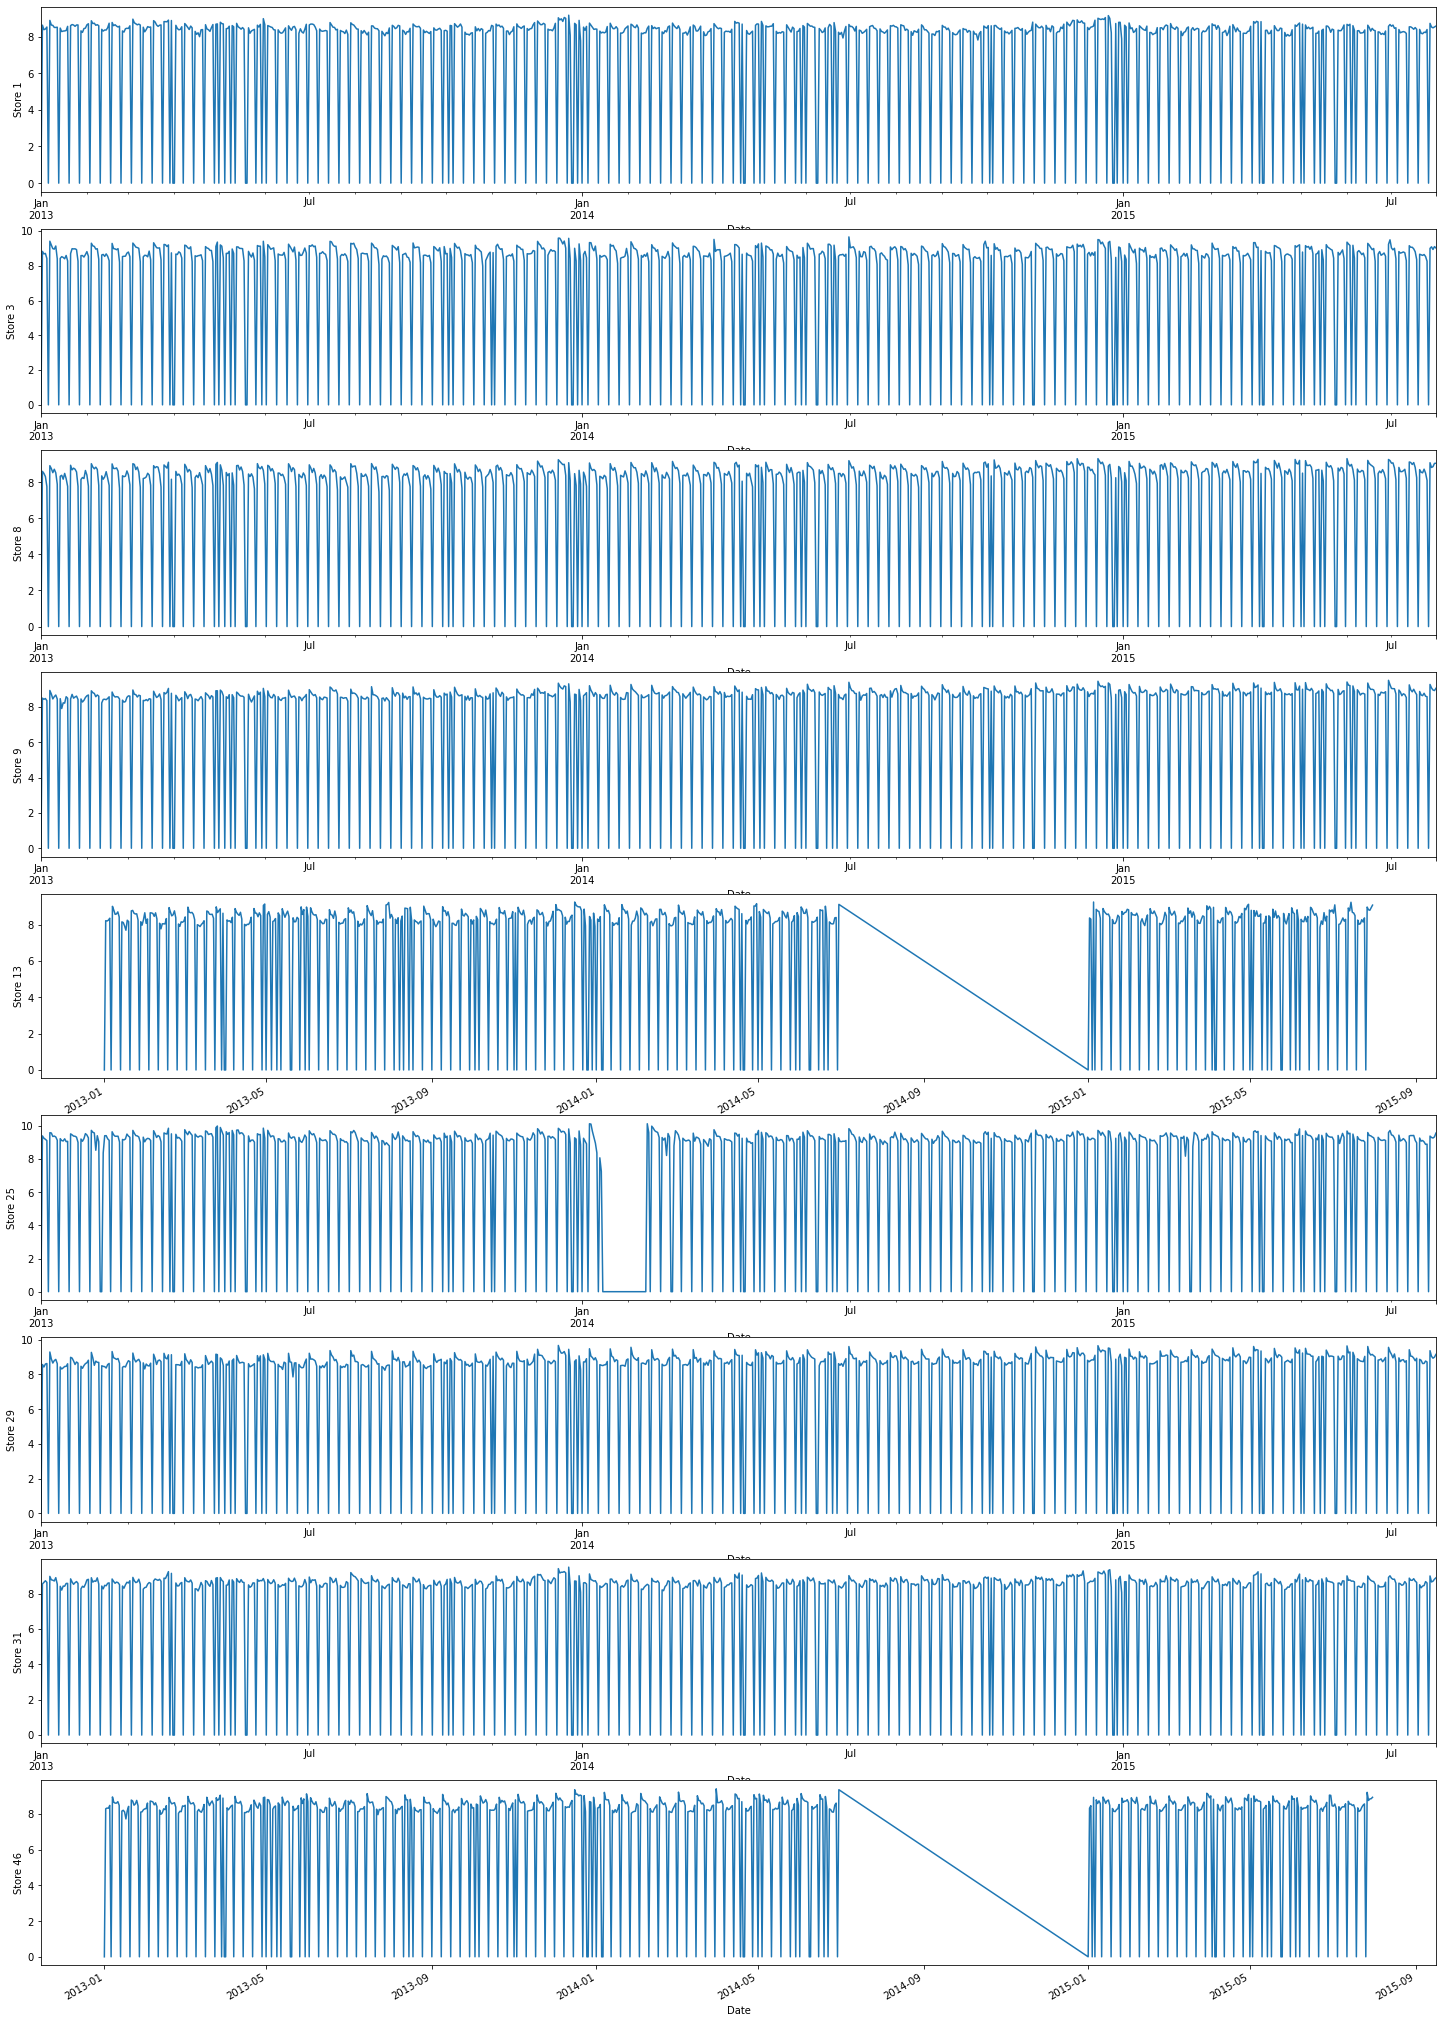

In [45]:
# Plotting Log_Sales for store types selected
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize = (25, 40))
store_1_sales.Log_Sales.plot(ax = ax1)
ax1.set_ylabel('Store 1')

store_3_sales.Log_Sales.plot(ax = ax2)
ax2.set_ylabel('Store 3')

store_8_sales.Log_Sales.plot(ax = ax3)
ax3.set_ylabel('Store 8')

store_9_sales.Log_Sales.plot(ax = ax4)
ax4.set_ylabel('Store 9')

store_13_sales.Log_Sales.plot(ax = ax5)
ax5.set_ylabel('Store 13')

store_25_sales.Log_Sales.plot(ax = ax6)
ax6.set_ylabel('Store 25')

store_29_sales.Log_Sales.plot(ax = ax7)
ax7.set_ylabel('Store 29')

store_31_sales.Log_Sales.plot(ax = ax8)
ax8.set_ylabel('Store 31')

store_46_sales.Log_Sales.plot(ax = ax9)
ax9.set_ylabel('Store 46')

plt.show()

In [46]:
# Checking shape of dataset
print('Shape of Store 1:',store_1_sales.shape)
print('Shape of Store 3:',store_3_sales.shape)
print('Shape of Store 8:',store_8_sales.shape)
print('Shape of Store 9:',store_9_sales.shape)
print('Shape of Store 13:',store_13_sales.shape)
print('Shape of Store 25:',store_25_sales.shape)
print('Shape of Store 29:',store_29_sales.shape)
print('Shape of Store 31:',store_31_sales.shape)
print('Shape of Store 46:',store_46_sales.shape)

Shape of Store 1: (942, 13)
Shape of Store 3: (942, 13)
Shape of Store 8: (942, 13)
Shape of Store 9: (942, 13)
Shape of Store 13: (758, 13)
Shape of Store 25: (942, 13)
Shape of Store 29: (942, 13)
Shape of Store 31: (942, 13)
Shape of Store 46: (758, 13)


In [47]:
# Splitting dataset to train & test data
train_len = 750
train_len_1 = 600
train_store_1_sales =store_1_sales[0:train_len]
test_store_1_sales =store_1_sales[train_len:]
train_store_3_sales =store_3_sales[0:train_len]
test_store_3_sales =store_3_sales[train_len:]
train_store_8_sales =store_8_sales[0:train_len]
test_store_8_sales =store_8_sales[train_len:]
train_store_9_sales =store_9_sales[0:train_len]
test_store_9_sales =store_9_sales[train_len:]
train_store_13_sales =store_13_sales[0:train_len_1]
test_store_13_sales =store_13_sales[train_len_1:]
train_store_25_sales =store_25_sales[0:train_len]
test_store_25_sales =store_25_sales[train_len:]
train_store_29_sales =store_29_sales[0:train_len]
test_store_29_sales =store_29_sales[train_len:]
train_store_31_sales =store_31_sales[0:train_len]
test_store_31_sales =store_31_sales[train_len:]
train_store_46_sales =store_46_sales[0:train_len_1]
test_store_46_sales =store_46_sales[train_len_1:]

In [48]:
# Converting Log values to Series data
store_1_Log_Sales = pd.Series(store_1_sales['Log_Sales'], index = store_1_sales.index)
store_3_Log_Sales = pd.Series(store_3_sales['Log_Sales'], index = store_3_sales.index)
store_8_Log_Sales = pd.Series(store_8_sales['Log_Sales'], index = store_8_sales.index)
store_9_Log_Sales = pd.Series(store_9_sales['Log_Sales'], index = store_9_sales.index)
store_13_Log_Sales = pd.Series(store_13_sales['Log_Sales'], index = store_13_sales.index)
store_13_Log_Sales = store_13_Log_Sales.asfreq('D')
store_13_Log_Sales = store_13_Log_Sales.fillna(0)
store_25_Log_Sales = pd.Series(store_25_sales['Log_Sales'], index = store_25_sales.index)
store_29_Log_Sales = pd.Series(store_29_sales['Log_Sales'], index = store_29_sales.index)
store_31_Log_Sales = pd.Series(store_31_sales['Log_Sales'], index = store_31_sales.index)
store_46_Log_Sales = pd.Series(store_46_sales['Log_Sales'], index = store_46_sales.index)
store_46_Log_Sales = store_46_Log_Sales.asfreq('D')
store_46_Log_Sales = store_46_Log_Sales.fillna(0)

In [49]:
# Checking stationarity
store_name = [1, 3, 8, 9, 13, 25, 29, 31, 46]
ls = [store_1_Log_Sales, store_3_Log_Sales, store_8_Log_Sales, store_9_Log_Sales, store_13_Log_Sales, store_25_Log_Sales, 
      store_29_Log_Sales, store_31_Log_Sales, store_46_Log_Sales]

for i in range(len(ls)):
    print('\n\nADF test results for Store ' + str(store_name[i]) + ':\n')
    result = adfuller(ls[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            sig_val = value
            print('\t%s: %.3f' % (key, value))
    if (result[0] < sig_val):
        print('Time -series is stationary')
    else:
        print('Time -series is non - stationary')



ADF test results for Store 1:

ADF Statistic: -5.733326
p-value: 0.000001
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 3:

ADF Statistic: -6.115979
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 8:

ADF Statistic: -6.206257
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 9:

ADF Statistic: -5.913939
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 13:

ADF Statistic: -1.624662
p-value: 0.470286
Critical Values:
	5%: -2.865
Time -series is non - stationary


ADF test results for Store 25:

ADF Statistic: -3.814324
p-value: 0.002764
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 29:

ADF Statistic: -5.951745
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 31:

ADF Statistic: -6.205092
p-value:

In [50]:
# Creating first difference of stores for further stationarity
store_1_DLog_Sales = pd.Series(store_1_Log_Sales - store_1_Log_Sales.shift(), index = store_1_sales.index)
store_3_DLog_Sales = pd.Series(store_3_Log_Sales - store_3_Log_Sales.shift(), index = store_3_sales.index)
store_8_DLog_Sales = pd.Series(store_8_Log_Sales - store_8_Log_Sales.shift(), index = store_8_sales.index)
store_9_DLog_Sales = pd.Series(store_9_Log_Sales - store_9_Log_Sales.shift(), index = store_9_sales.index)
store_13_DLog_Sales = pd.Series(store_13_Log_Sales - store_13_Log_Sales.shift(), index = store_13_sales.index)
store_25_DLog_Sales = pd.Series(store_25_Log_Sales - store_25_Log_Sales.shift(), index = store_25_sales.index)
store_29_DLog_Sales = pd.Series(store_29_Log_Sales - store_29_Log_Sales.shift(), index = store_29_sales.index)
store_31_DLog_Sales = pd.Series(store_31_Log_Sales - store_31_Log_Sales.shift(), index = store_31_sales.index)
store_46_DLog_Sales = pd.Series(store_46_Log_Sales - store_46_Log_Sales.shift(), index = store_46_sales.index)

In [51]:
# Checking stationarity
store_name = [1, 3, 8, 9, 13, 25, 29, 31, 46]
ls = [store_1_DLog_Sales, store_3_DLog_Sales, store_8_DLog_Sales, store_9_DLog_Sales, store_13_DLog_Sales, 
      store_25_DLog_Sales, store_29_DLog_Sales, store_31_DLog_Sales, store_46_DLog_Sales]

for i in range(len(ls)):
    print('\n\nADF test results for Store ' + str(store_name[i]) + ':\n')
    result = adfuller(ls[i].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            sig_val = value
            print('\t%s: %.3f' % (key, value))
    if (result[0] < sig_val):
        print('Time -series is stationary')
    else:
        print('Time -series is non - stationary')



ADF test results for Store 1:

ADF Statistic: -12.948888
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 3:

ADF Statistic: -13.154896
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 8:

ADF Statistic: -12.241397
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 9:

ADF Statistic: -12.950847
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 13:

ADF Statistic: -7.286059
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 25:

ADF Statistic: -8.329752
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 29:

ADF Statistic: -13.090547
p-value: 0.000000
Critical Values:
	5%: -2.865
Time -series is stationary


ADF test results for Store 31:

ADF Statistic: -12.504397
p-value:

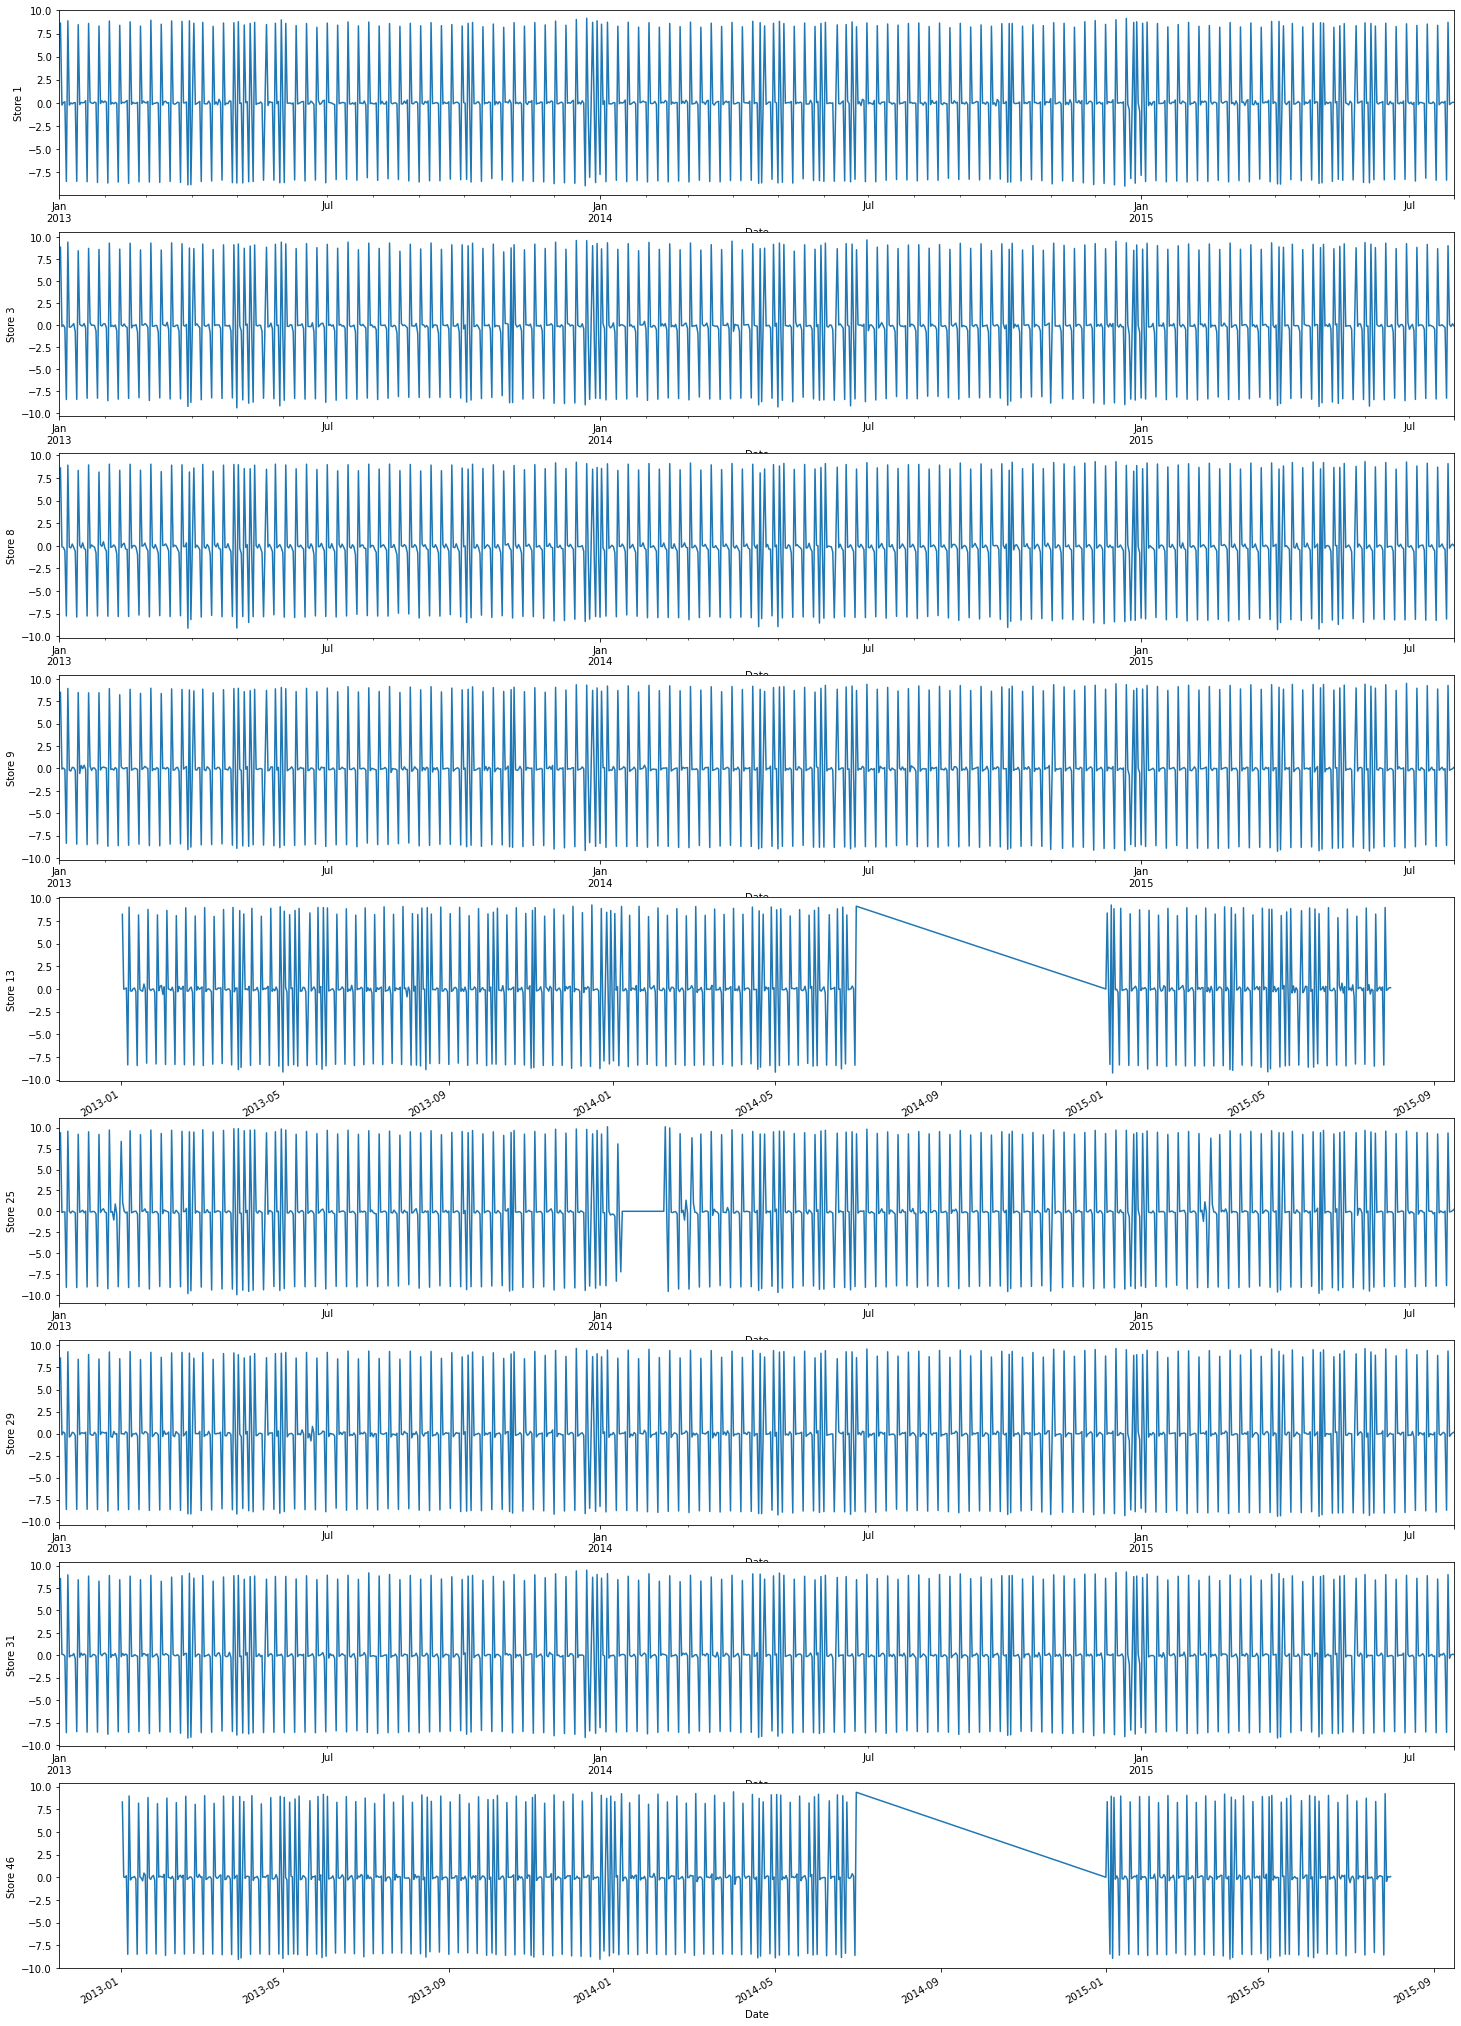

In [52]:
# Plotting DLog_Sales for store types selected
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize = (25, 40))
store_1_DLog_Sales.plot(ax = ax1)
ax1.set_ylabel('Store 1')

store_3_DLog_Sales.plot(ax = ax2)
ax2.set_ylabel('Store 3')

store_8_DLog_Sales.plot(ax = ax3)
ax3.set_ylabel('Store 8')

store_9_DLog_Sales.plot(ax = ax4)
ax4.set_ylabel('Store 9')

store_13_DLog_Sales.plot(ax = ax5)
ax5.set_ylabel('Store 13')

store_25_DLog_Sales.plot(ax = ax6)
ax6.set_ylabel('Store 25')

store_29_DLog_Sales.plot(ax = ax7)
ax7.set_ylabel('Store 29')

store_31_DLog_Sales.plot(ax = ax8)
ax8.set_ylabel('Store 31')

store_46_DLog_Sales.plot(ax = ax9)
ax9.set_ylabel('Store 46')

plt.show()

#### SARIMA Model Building

Building SARIMA model for each historic stores

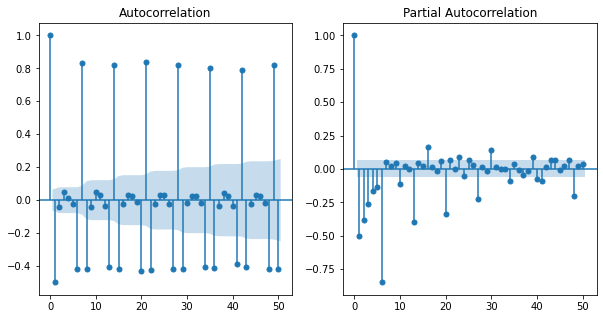

In [53]:
#Plotting ACF & PACF for store 1
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(store_1_DLog_Sales.dropna(), lags = 50, ax = ax[0])
plot_pacf(store_1_DLog_Sales.dropna(), lags = 50, ax = ax[1])
plt.show()

In [54]:
# Splitting into train & test dataset
train_len = 750
train_len_1 = 600
train_store_1_Log_Sales =store_1_Log_Sales[0:train_len]
test_store_1_Log_Sales =store_1_Log_Sales[train_len:]
train_store_3_Log_Sales =store_3_Log_Sales[0:train_len]
test_store_3_Log_Sales =store_3_Log_Sales[train_len:]
train_store_8_Log_Sales =store_8_Log_Sales[0:train_len]
test_store_8_Log_Sales =store_8_Log_Sales[train_len:]
train_store_9_Log_Sales =store_9_Log_Sales[0:train_len]
test_store_9_Log_Sales =store_9_Log_Sales[train_len:]
train_store_13_Log_Sales =store_13_Log_Sales[0:train_len_1]
test_store_13_Log_Sales =store_13_Log_Sales[train_len_1:]
train_store_25_Log_Sales =store_25_Log_Sales[0:train_len]
test_store_25_Log_Sales =store_25_Log_Sales[train_len:]
train_store_29_Log_Sales =store_29_Log_Sales[0:train_len]
test_store_29_Log_Sales =store_29_Log_Sales[train_len:]
train_store_31_Log_Sales =store_31_Log_Sales[0:train_len]
test_store_31_Log_Sales =store_31_Log_Sales[train_len:]
train_store_46_Log_Sales =store_46_Log_Sales[0:train_len_1]
test_store_46_Log_Sales =store_46_Log_Sales[train_len_1:]

In [55]:
# SARIMA model for Store 1
model = SARIMAX(train_store_1_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12)) 
model_fit_1sa = model.fit()
print(model_fit_1sa.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -1.583079
ar.L2      -1.739285
ar.L3      -1.700181
ar.L4      -1.777762
ar.L5      -1.767242
ar.L6      -1.749394
ar.L7      -0.777648
ar.L8      -0.202677
ar.L9      -0.065644
ar.L10     -0.096583
ma.L1       0.552221
ma.L2       0.136450
ma.L3      -0.041063
ma.L4      -0.015652
ma.L5      -0.138161
ma.L6      -0.060817
ma.L7      -0.844125
ma.L8      -0.535431
ar.S.L12   -0.644048
ar.S.L24   -0.431916
sigma2      3.392003
dtype: float64


In [56]:
# Predicting Sales for Store 1
y_hat_sarima_store_1 = store_1_Log_Sales.copy()
y_hat_sarima_store_1['Sarima_Forecast_Log_Sales'] = model_fit_1sa.predict(store_1_Log_Sales.index.min(),store_1_Log_Sales.index.max())
y_hat_sarima_store_1['Sarima_Forecast_Sales'] = np.exp(y_hat_sarima_store_1['Sarima_Forecast_Log_Sales'])

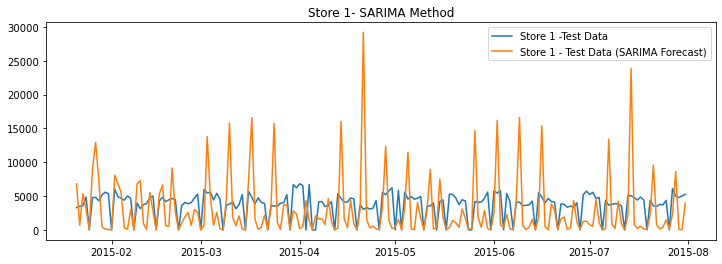

In [57]:
# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_1_sales['Sales'], label='Store 1 -Test Data')
plt.plot(y_hat_sarima_store_1['Sarima_Forecast_Sales'][test_store_1_sales.index.min():], label='Store 1 - Test Data (SARIMA Forecast)')
plt.legend(loc='best')
plt.title('Store 1- SARIMA Method')
plt.show()

In [58]:
# Calculating RMSE & MAPE values for Store 1
rmse = np.sqrt(mean_squared_error(test_store_1_sales['Sales'], y_hat_sarima_store_1['Sarima_Forecast_Sales'][test_store_1_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_1_sales['Sales']-y_hat_sarima_store_1['Sarima_Forecast_Sales'][test_store_1_sales.index.min():])/test_store_1_sales['Sales'])*100,2)

results = pd.DataFrame({'Store' : 'Store 1', 'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
#results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store         Method     RMSE     MAPE
0  Store 1  SARIMA method  4624.91  4547.56

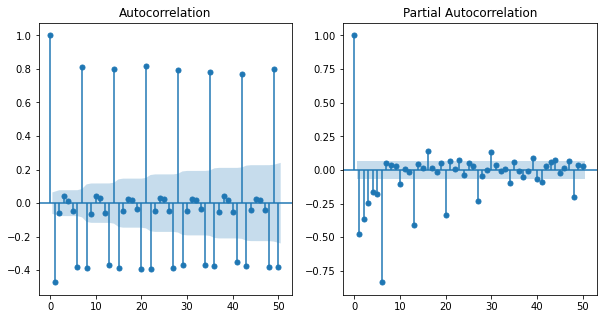

In [59]:
#Plotting ACF & PACF for store 3
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(store_3_DLog_Sales.dropna(), lags = 50, ax = ax[0])
plot_pacf(store_3_DLog_Sales.dropna(), lags = 50, ax = ax[1])
plt.show()

In [60]:
# SARIMA model for Store 3
model = SARIMAX(train_store_3_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12)) 
model_fit_3sa = model.fit()
print(model_fit_3sa.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -1.713233
ar.L2      -2.035623
ar.L3      -2.067136
ar.L4      -2.481002
ar.L5      -2.458933
ar.L6      -2.445604
ar.L7      -1.467704
ar.L8      -0.739101
ar.L9      -0.458450
ar.L10     -0.398532
ma.L1       0.651869
ma.L2       0.448099
ma.L3       0.087326
ma.L4       0.327041
ma.L5      -0.006030
ma.L6       0.002768
ma.L7      -0.624730
ma.L8      -0.523891
ar.S.L12   -0.541488
ar.S.L24   -0.363555
sigma2      4.345909
dtype: float64


In [61]:
# Predicting Sales for Store 3
y_hat_sarima_store_3 = store_3_Log_Sales.copy()
y_hat_sarima_store_3['Sarima_Forecast_Log_Sales'] = model_fit_3sa.predict(store_3_Log_Sales.index.min(),store_3_Log_Sales.index.max())
y_hat_sarima_store_3['Sarima_Forecast_Sales'] = np.exp(y_hat_sarima_store_3['Sarima_Forecast_Log_Sales'])

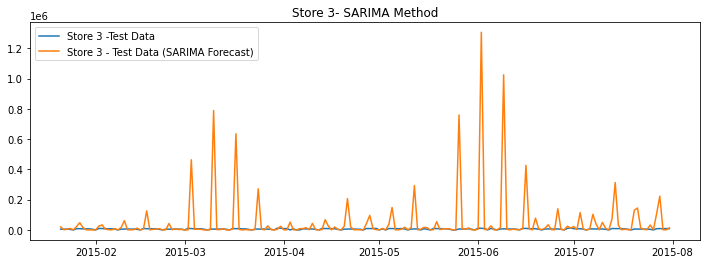

In [62]:
# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_3_sales['Sales'], label='Store 3 -Test Data')
plt.plot(y_hat_sarima_store_3['Sarima_Forecast_Sales'][test_store_3_sales.index.min():], label='Store 3 - Test Data (SARIMA Forecast)')
plt.legend(loc='best')
plt.title('Store 3- SARIMA Method')
plt.show()

In [63]:
# Calculating RMSE & MAPE values for Store 3
rmse = np.sqrt(mean_squared_error(test_store_3_sales['Sales'], y_hat_sarima_store_3['Sarima_Forecast_Sales'][test_store_3_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_3_sales['Sales']-y_hat_sarima_store_3['Sarima_Forecast_Sales'][test_store_3_sales.index.min():])/test_store_3_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 3', 'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store         Method       RMSE      MAPE
0  Store 1  SARIMA method    4624.91   4547.56
0  Store 3  SARIMA method  163984.79  40973.45

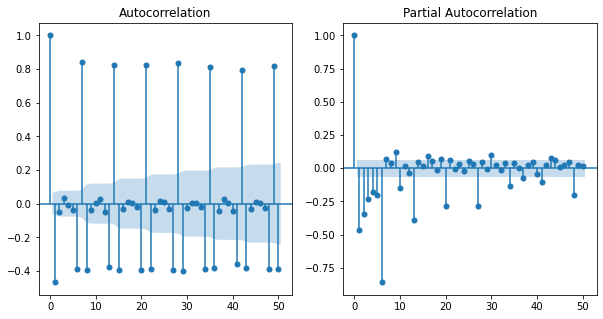

In [64]:
#Plotting ACF & PACF for store 8
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(store_8_DLog_Sales.dropna(), lags = 50, ax = ax[0])
plot_pacf(store_8_DLog_Sales.dropna(), lags = 50, ax = ax[1])
plt.show()

In [65]:
# SARIMA model for Store 8
model = SARIMAX(train_store_8_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12)) 
model_fit_8sa = model.fit()
print(model_fit_8sa.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -1.517733
ar.L2      -1.666862
ar.L3      -1.398732
ar.L4      -1.517482
ar.L5      -1.520944
ar.L6      -1.499592
ar.L7      -0.537380
ar.L8      -0.004988
ar.L9       0.121263
ar.L10     -0.127187
ma.L1       0.501306
ma.L2       0.219805
ma.L3      -0.057974
ma.L4       0.117756
ma.L5       0.041849
ma.L6      -0.025311
ma.L7      -0.639239
ma.L8      -0.418949
ar.S.L12   -0.567974
ar.S.L24   -0.313893
sigma2      3.283363
dtype: float64


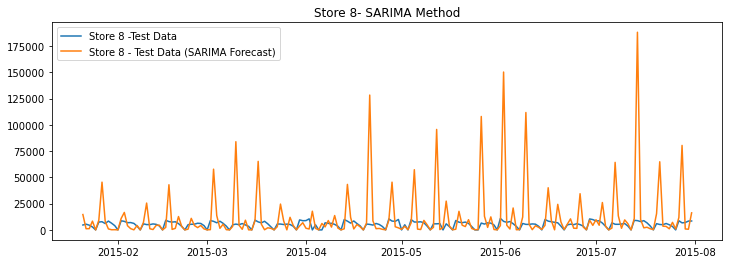

In [66]:
# Predicting Sales for Store 8
y_hat_sarima_store_8 = store_8_Log_Sales.copy()
y_hat_sarima_store_8['Sarima_Forecast_Log_Sales'] = model_fit_8sa.predict(store_8_Log_Sales.index.min(),store_8_Log_Sales.index.max())
y_hat_sarima_store_8['Sarima_Forecast_Sales'] = np.exp(y_hat_sarima_store_8['Sarima_Forecast_Log_Sales'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_8_sales['Sales'], label='Store 8 -Test Data')
plt.plot(y_hat_sarima_store_8['Sarima_Forecast_Sales'][test_store_8_sales.index.min():], label='Store 8 - Test Data (SARIMA Forecast)')
plt.legend(loc='best')
plt.title('Store 8- SARIMA Method')
plt.show()

In [67]:
# Calculating RMSE & MAPE values for Store 8
rmse = np.sqrt(mean_squared_error(test_store_8_sales['Sales'], y_hat_sarima_store_8['Sarima_Forecast_Sales'][test_store_8_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_8_sales['Sales']-y_hat_sarima_store_8['Sarima_Forecast_Sales'][test_store_8_sales.index.min():])/test_store_8_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 8', 'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store         Method       RMSE      MAPE
0  Store 1  SARIMA method    4624.91   4547.56
0  Store 3  SARIMA method  163984.79  40973.45
0  Store 8  SARIMA method   26705.61  16107.89

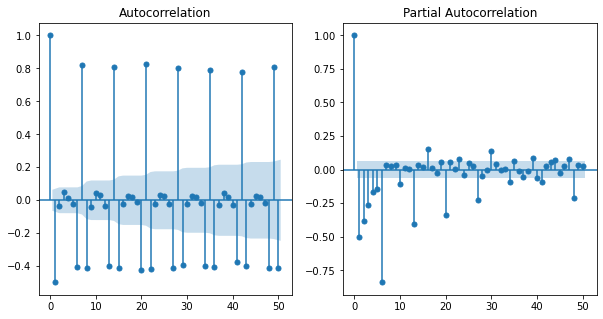

In [68]:
#Plotting ACF & PACF for store 9
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(store_9_DLog_Sales.dropna(), lags = 50, ax = ax[0])
plot_pacf(store_9_DLog_Sales.dropna(), lags = 50, ax = ax[1])
plt.show()

In [69]:
# SARIMA model for Store 9
model = SARIMAX(train_store_9_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12)) 
model_fit_9sa = model.fit()
print(model_fit_9sa.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -1.773460
ar.L2      -2.063553
ar.L3      -2.038293
ar.L4      -2.038822
ar.L5      -2.030092
ar.L6      -2.001139
ar.L7      -1.020245
ar.L8      -0.253503
ar.L9       0.014519
ar.L10     -0.015832
ma.L1       0.643331
ma.L2       0.188255
ma.L3      -0.001646
ma.L4      -0.044489
ma.L5      -0.140905
ma.L6      -0.172786
ma.L7      -0.856056
ma.L8      -0.568351
ar.S.L12   -0.490597
ar.S.L24   -0.253062
sigma2      4.190084
dtype: float64


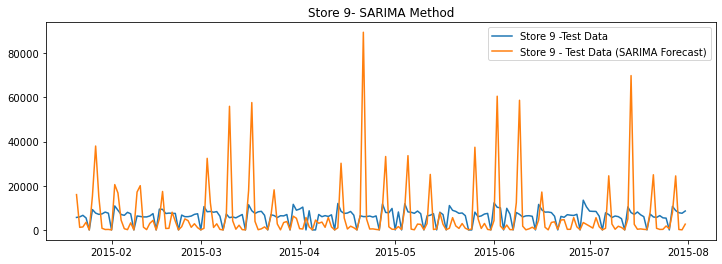

In [70]:
# Predicting Sales for Store 9
y_hat_sarima_store_9 = store_9_Log_Sales.copy()
y_hat_sarima_store_9['Sarima_Forecast_Log_Sales'] = model_fit_9sa.predict(store_9_Log_Sales.index.min(),store_9_Log_Sales.index.max())
y_hat_sarima_store_9['Sarima_Forecast_Sales'] = np.exp(y_hat_sarima_store_9['Sarima_Forecast_Log_Sales'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_9_sales['Sales'], label='Store 9 -Test Data')
plt.plot(y_hat_sarima_store_9['Sarima_Forecast_Sales'][test_store_9_sales.index.min():], label='Store 9 - Test Data (SARIMA Forecast)')
plt.legend(loc='best')
plt.title('Store 9- SARIMA Method')
plt.show()

In [71]:
# Calculating RMSE & MAPE values for Store 9
rmse = np.sqrt(mean_squared_error(test_store_9_sales['Sales'], y_hat_sarima_store_9['Sarima_Forecast_Sales'][test_store_9_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_9_sales['Sales']-y_hat_sarima_store_9['Sarima_Forecast_Sales'][test_store_9_sales.index.min():])/test_store_9_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 9', 'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store         Method       RMSE      MAPE
0  Store 1  SARIMA method    4624.91   4547.56
0  Store 3  SARIMA method  163984.79  40973.45
0  Store 8  SARIMA method   26705.61  16107.89
0  Store 9  SARIMA method   12834.35   7240.21

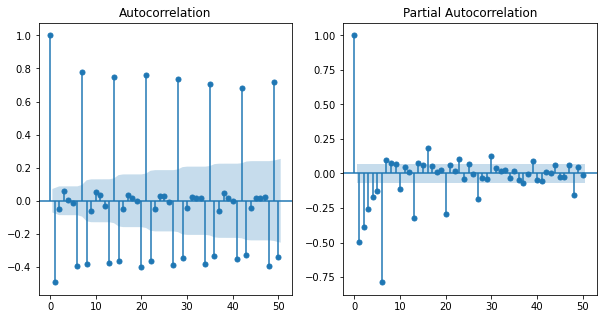

In [72]:
#Plotting ACF & PACF for store 13
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(store_13_DLog_Sales.dropna(), lags = 50, ax = ax[0])
plot_pacf(store_13_DLog_Sales.dropna(), lags = 50, ax = ax[1])
plt.show()

In [73]:
# SARIMA model for Store 13
model = SARIMAX(train_store_13_Log_Sales, order=(10, 1, 7), seasonal_order=(2, 1, 0, 12)) 
model_fit_13sa = model.fit()
print(model_fit_13sa.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -0.737590
ar.L2      -0.665867
ar.L3      -0.555484
ar.L4      -0.438582
ar.L5      -0.452018
ar.L6      -0.432263
ar.L7       0.536261
ar.L8       0.297841
ar.L9       0.212797
ar.L10      0.108535
ma.L1      -0.123719
ma.L2       0.018253
ma.L3       0.040663
ma.L4      -0.052670
ma.L5       0.080038
ma.L6      -0.066613
ma.L7      -0.737520
ar.S.L12   -0.633235
ar.S.L24   -0.342583
sigma2      4.792355
dtype: float64


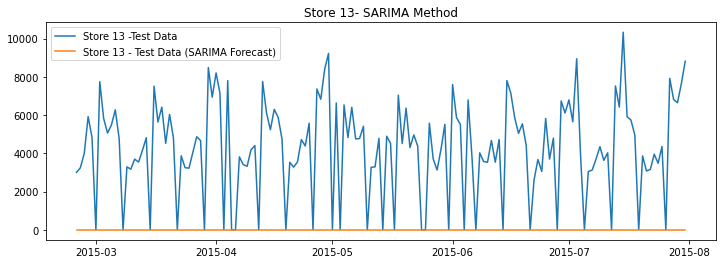

In [74]:
# Predicting Sales for Store 13
y_hat_sarima_store_13 = store_13_Log_Sales.copy()
y_hat_sarima_store_13['Sarima_Forecast_Log_Sales'] = model_fit_13sa.predict(store_13_Log_Sales.index.min(),store_13_Log_Sales.index.max())
y_hat_sarima_store_13['Sarima_Forecast_Sales'] = np.exp(y_hat_sarima_store_13['Sarima_Forecast_Log_Sales'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_13_sales['Sales'], label='Store 13 -Test Data')
plt.plot(y_hat_sarima_store_13['Sarima_Forecast_Sales'][test_store_13_sales.index.min():], label='Store 13 - Test Data (SARIMA Forecast)')
plt.legend(loc='best')
plt.title('Store 13- SARIMA Method')
plt.show()

In [75]:
# Calculating RMSE & MAPE values for Store 13
rmse = np.sqrt(mean_squared_error(test_store_13_sales['Sales'], y_hat_sarima_store_13['Sarima_Forecast_Sales'][test_store_13_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_13_sales['Sales']-y_hat_sarima_store_13['Sarima_Forecast_Sales'][test_store_13_sales.index.min():])/test_store_13_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 13', 'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store         Method       RMSE      MAPE
0   Store 1  SARIMA method    4624.91   4547.56
0   Store 3  SARIMA method  163984.79  40973.45
0   Store 8  SARIMA method   26705.61  16107.89
0   Store 9  SARIMA method   12834.35   7240.21
0  Store 13  SARIMA method    4944.74    100.00

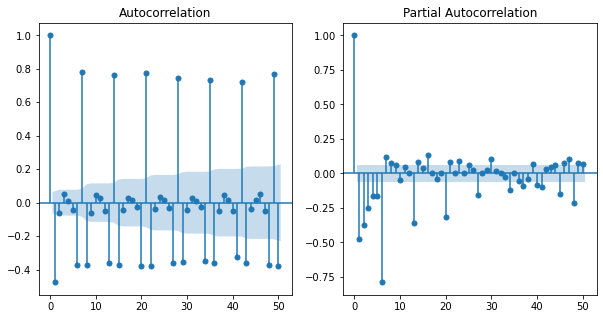

In [76]:
#Plotting ACF & PACF for store 25
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(store_25_DLog_Sales.dropna(), lags = 50, ax = ax[0])
plot_pacf(store_25_DLog_Sales.dropna(), lags = 50, ax = ax[1])
plt.show()

In [77]:
# SARIMA model for Store 25
model = SARIMAX(train_store_25_Log_Sales, order=(8, 1, 8), seasonal_order=(2, 1, 0, 12)) 
model_fit_25sa = model.fit()
print(model_fit_25sa.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -0.188263
ar.L2      -0.361453
ar.L3      -0.350274
ar.L4      -0.350238
ar.L5      -0.355145
ar.L6      -0.351223
ar.L7       0.629771
ar.L8      -0.167778
ma.L1      -0.571598
ma.L2       0.151982
ma.L3       0.094975
ma.L4       0.076132
ma.L5       0.184024
ma.L6       0.097581
ma.L7      -0.705265
ma.L8       0.554989
ar.S.L12   -0.721336
ar.S.L24   -0.320563
sigma2      6.291294
dtype: float64


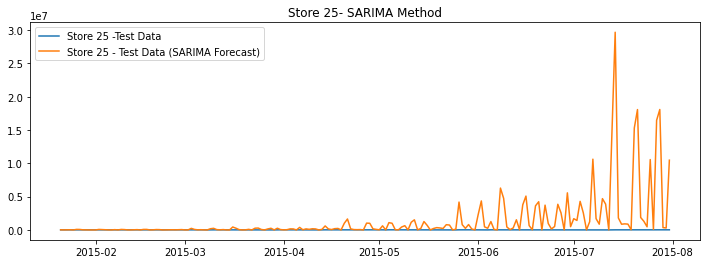

In [78]:
# Predicting Sales for Store 25
y_hat_sarima_store_25 = store_25_Log_Sales.copy()
y_hat_sarima_store_25['Sarima_Forecast_Log_Sales'] = model_fit_25sa.predict(store_25_Log_Sales.index.min(),store_25_Log_Sales.index.max())
y_hat_sarima_store_25['Sarima_Forecast_Sales'] = np.exp(y_hat_sarima_store_25['Sarima_Forecast_Log_Sales'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_25_sales['Sales'], label='Store 25 -Test Data')
plt.plot(y_hat_sarima_store_25['Sarima_Forecast_Sales'][test_store_25_sales.index.min():], label='Store 25 - Test Data (SARIMA Forecast)')
plt.legend(loc='best')
plt.title('Store 25- SARIMA Method')
plt.show()

In [79]:
# Calculating RMSE & MAPE values for Store 25
rmse = np.sqrt(mean_squared_error(test_store_25_sales['Sales'], y_hat_sarima_store_25['Sarima_Forecast_Sales'][test_store_25_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_25_sales['Sales']-y_hat_sarima_store_25['Sarima_Forecast_Sales'][test_store_25_sales.index.min():])/test_store_25_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 25', 'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store         Method        RMSE       MAPE
0   Store 1  SARIMA method     4624.91    4547.56
0   Store 3  SARIMA method   163984.79   40973.45
0   Store 8  SARIMA method    26705.61   16107.89
0   Store 9  SARIMA method    12834.35    7240.21
0  Store 13  SARIMA method     4944.74     100.00
0  Store 25  SARIMA method  3913891.97  720410.80

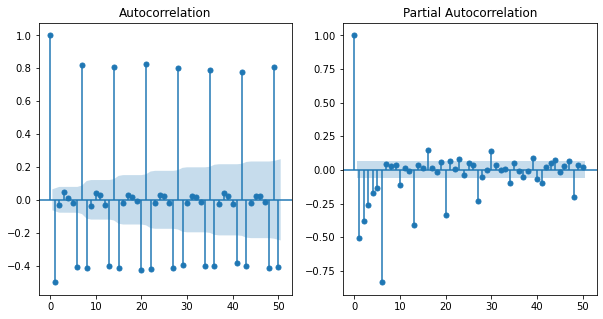

In [80]:
#Plotting ACF & PACF for store 29
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(store_29_DLog_Sales.dropna(), lags = 50, ax = ax[0])
plot_pacf(store_29_DLog_Sales.dropna(), lags = 50, ax = ax[1])
plt.show()

In [81]:
# SARIMA model for Store 29
model = SARIMAX(train_store_29_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12)) 
model_fit_29sa = model.fit()
print(model_fit_29sa.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -1.861200
ar.L2      -2.194476
ar.L3      -2.174519
ar.L4      -2.472611
ar.L5      -2.460289
ar.L6      -2.448582
ar.L7      -1.469478
ar.L8      -0.594230
ar.L9      -0.290083
ar.L10     -0.290100
ma.L1       0.723658
ma.L2       0.401659
ma.L3       0.134073
ma.L4       0.347066
ma.L5       0.110615
ma.L6       0.077317
ma.L7      -0.539394
ma.L8      -0.503329
ar.S.L12   -0.541908
ar.S.L24   -0.321471
sigma2      4.484426
dtype: float64


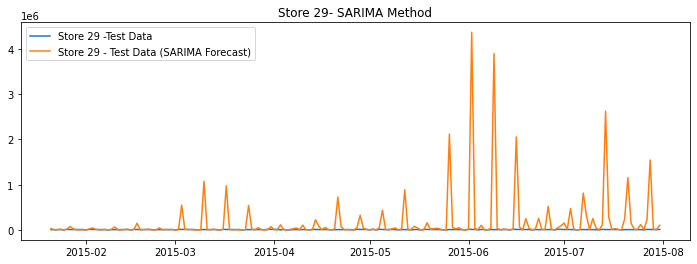

In [82]:
# Predicting Sales for Store 29
y_hat_sarima_store_29 = store_29_Log_Sales.copy()
y_hat_sarima_store_29['Sarima_Forecast_Log_Sales'] = model_fit_29sa.predict(store_29_Log_Sales.index.min(),store_29_Log_Sales.index.max())
y_hat_sarima_store_29['Sarima_Forecast_Sales'] = np.exp(y_hat_sarima_store_29['Sarima_Forecast_Log_Sales'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_29_sales['Sales'], label='Store 29 -Test Data')
plt.plot(y_hat_sarima_store_29['Sarima_Forecast_Sales'][test_store_29_sales.index.min():], label='Store 29 - Test Data (SARIMA Forecast)')
plt.legend(loc='best')
plt.title('Store 29- SARIMA Method')
plt.show()

In [83]:
# Calculating RMSE & MAPE values for Store 29
rmse = np.sqrt(mean_squared_error(test_store_29_sales['Sales'], y_hat_sarima_store_29['Sarima_Forecast_Sales'][test_store_29_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_29_sales['Sales']-y_hat_sarima_store_29['Sarima_Forecast_Sales'][test_store_29_sales.index.min():])/test_store_29_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 29', 'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store         Method        RMSE       MAPE
0   Store 1  SARIMA method     4624.91    4547.56
0   Store 3  SARIMA method   163984.79   40973.45
0   Store 8  SARIMA method    26705.61   16107.89
0   Store 9  SARIMA method    12834.35    7240.21
0  Store 13  SARIMA method     4944.74     100.00
0  Store 25  SARIMA method  3913891.97  720410.80
0  Store 29  SARIMA method   556344.15   89601.82

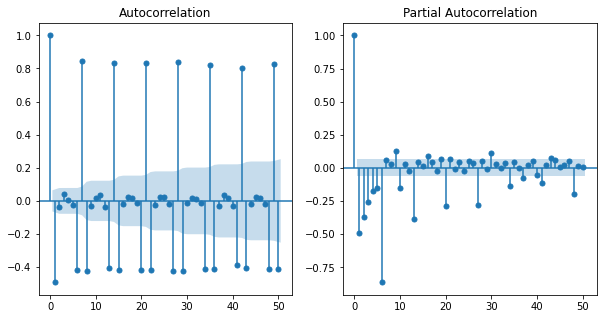

In [84]:
#Plotting ACF & PACF for store 31
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(store_31_DLog_Sales.dropna(), lags = 50, ax = ax[0])
plot_pacf(store_31_DLog_Sales.dropna(), lags = 50, ax = ax[1])
plt.show()

In [85]:
# SARIMA model for Store 31
model = SARIMAX(train_store_31_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12)) 
model_fit_31sa = model.fit()
print(model_fit_31sa.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -1.556532
ar.L2      -1.734540
ar.L3      -1.466576
ar.L4      -1.586573
ar.L5      -1.581970
ar.L6      -1.568254
ar.L7      -0.599905
ar.L8      -0.034490
ar.L9       0.123042
ar.L10     -0.126430
ma.L1       0.501974
ma.L2       0.202624
ma.L3      -0.059860
ma.L4       0.141502
ma.L5       0.046076
ma.L6       0.019683
ma.L7      -0.650652
ma.L8      -0.419356
ar.S.L12   -0.572127
ar.S.L24   -0.281960
sigma2      3.229271
dtype: float64


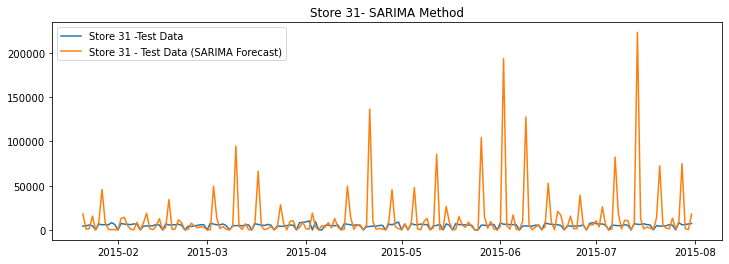

In [86]:
# Predicting Sales for Store 31
y_hat_sarima_store_31 = store_31_Log_Sales.copy()
y_hat_sarima_store_31['Sarima_Forecast_Log_Sales'] = model_fit_31sa.predict(store_31_Log_Sales.index.min(),store_31_Log_Sales.index.max())
y_hat_sarima_store_31['Sarima_Forecast_Sales'] = np.exp(y_hat_sarima_store_31['Sarima_Forecast_Log_Sales'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_31_sales['Sales'], label='Store 31 -Test Data')
plt.plot(y_hat_sarima_store_31['Sarima_Forecast_Sales'][test_store_29_sales.index.min():], label='Store 31 - Test Data (SARIMA Forecast)')
plt.legend(loc='best')
plt.title('Store 31- SARIMA Method')
plt.show()

In [87]:
# Calculating RMSE & MAPE values for Store 31
rmse = np.sqrt(mean_squared_error(test_store_31_sales['Sales'], y_hat_sarima_store_31['Sarima_Forecast_Sales'][test_store_31_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_31_sales['Sales']-y_hat_sarima_store_31['Sarima_Forecast_Sales'][test_store_31_sales.index.min():])/test_store_31_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 31', 'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store         Method        RMSE       MAPE
0   Store 1  SARIMA method     4624.91    4547.56
0   Store 3  SARIMA method   163984.79   40973.45
0   Store 8  SARIMA method    26705.61   16107.89
0   Store 9  SARIMA method    12834.35    7240.21
0  Store 13  SARIMA method     4944.74     100.00
0  Store 25  SARIMA method  3913891.97  720410.80
0  Store 29  SARIMA method   556344.15   89601.82
0  Store 31  SARIMA method    30375.75   15748.44

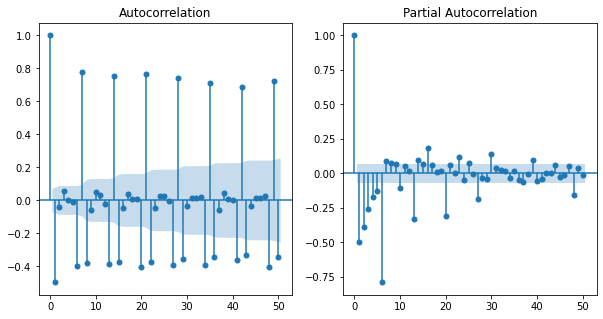

In [88]:
#Plotting ACF & PACF for store 46
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(store_46_DLog_Sales.dropna(), lags = 50, ax = ax[0])
plot_pacf(store_46_DLog_Sales.dropna(), lags = 50, ax = ax[1])
plt.show()

In [89]:
# SARIMA model for Store 46
model = SARIMAX(train_store_46_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12)) 
model_fit_46sa = model.fit()
print(model_fit_46sa.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -1.152779
ar.L2      -1.378952
ar.L3      -1.357559
ar.L4      -1.524333
ar.L5      -1.522807
ar.L6      -1.504063
ar.L7      -0.532116
ar.L8      -0.357299
ar.L9      -0.156876
ar.L10     -0.166673
ma.L1       0.258190
ma.L2       0.399224
ma.L3       0.226605
ma.L4       0.315712
ma.L5       0.160176
ma.L6       0.226973
ma.L7      -0.532234
ma.L8      -0.037896
ar.S.L12   -0.526701
ar.S.L24   -0.317074
sigma2      4.826224
dtype: float64


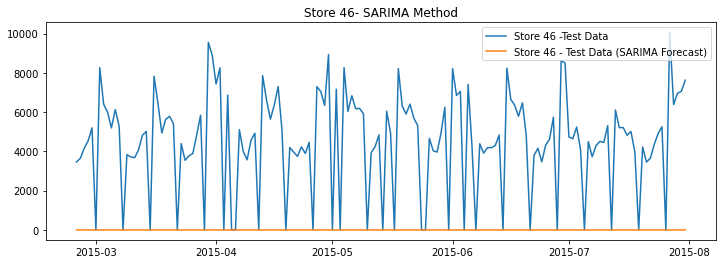

In [90]:
# Predicting Sales for Store 46
y_hat_sarima_store_46 = store_46_Log_Sales.copy()
y_hat_sarima_store_46['Sarima_Forecast_Log_Sales'] = model_fit_46sa.predict(store_46_Log_Sales.index.min(),store_46_Log_Sales.index.max())
y_hat_sarima_store_46['Sarima_Forecast_Sales'] = np.exp(y_hat_sarima_store_46['Sarima_Forecast_Log_Sales'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_46_sales['Sales'], label='Store 46 -Test Data')
plt.plot(y_hat_sarima_store_46['Sarima_Forecast_Sales'][test_store_46_sales.index.min():], label='Store 46 - Test Data (SARIMA Forecast)')
plt.legend(loc='best')
plt.title('Store 46- SARIMA Method')
plt.show()

In [91]:
# Calculating RMSE & MAPE values for Store 46
rmse = np.sqrt(mean_squared_error(test_store_46_sales['Sales'], y_hat_sarima_store_46['Sarima_Forecast_Sales'][test_store_46_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_46_sales['Sales']-y_hat_sarima_store_46['Sarima_Forecast_Sales'][test_store_46_sales.index.min():])/test_store_46_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 46', 'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store         Method        RMSE       MAPE
0   Store 1  SARIMA method     4624.91    4547.56
0   Store 3  SARIMA method   163984.79   40973.45
0   Store 8  SARIMA method    26705.61   16107.89
0   Store 9  SARIMA method    12834.35    7240.21
0  Store 13  SARIMA method     4944.74     100.00
0  Store 25  SARIMA method  3913891.97  720410.80
0  Store 29  SARIMA method   556344.15   89601.82
0  Store 31  SARIMA method    30375.75   15748.44
0  Store 46  SARIMA method     5173.41      87.74

#### SARIMAX Model Building

Building SARIMAX model for each historic stores

##### Store 1

In [92]:
# Assigning Customers & Promo as exogeneous variable
exog_store_1 = store_1_sales[['Promo', 'Customers']]
train_exog_store_1 = exog_store_1[0 : train_len]
test_exog_store_1 = exog_store_1[train_len : ]

In [93]:
# SARIMAX model for Store 1
model = SARIMAX(train_store_1_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12), exog = train_exog_store_1) 
model_fit_1 = model.fit(maxiter = 1000)
print(model_fit_1.params)

C:\Users\kalitanilotpole\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Promo        0.071928
Customers    1.329755
ar.L1       -0.621427
ar.L2       -1.329580
ar.L3       -1.021148
ar.L4       -1.036930
ar.L5       -1.192484
ar.L6       -0.535833
ar.L7       -0.592492
ar.L8        0.087490
ar.L9        0.093009
ar.L10       0.022033
ma.L1       -0.219982
ma.L2        0.783847
ma.L3       -0.211806
ma.L4       -0.009181
ma.L5        0.222666
ma.L6       -0.783879
ma.L7        0.209122
ma.L8       -0.990786
ar.S.L12    -0.577647
ar.S.L24    -0.217116
sigma2       0.003404
dtype: float64


In [94]:
# Predicting Sales for Store 1
y_hat_sarimax_store_1 = store_1_Log_Sales.copy()
y_hat_sarimax_store_1['Sarimax_Forecast_Log_Sales'] = model_fit_1.predict(store_1_Log_Sales.index.min(),store_1_Log_Sales.index.max(), exog = test_exog_store_1)
y_hat_sarimax_store_1['Sarimax_Forecast_Sales'] = np.exp(y_hat_sarimax_store_1['Sarimax_Forecast_Log_Sales'])

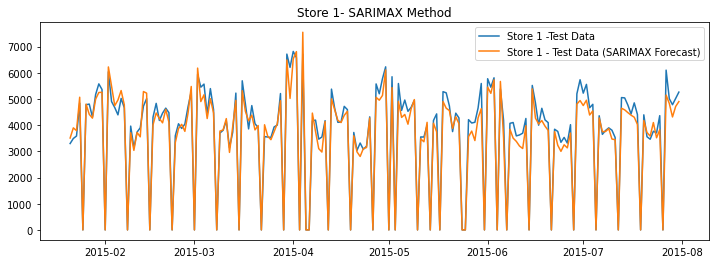

In [95]:
# Plotting test data and comparing with SARIMAX forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_1_sales['Sales'], label='Store 1 -Test Data')
plt.plot(y_hat_sarimax_store_1['Sarimax_Forecast_Sales'][test_store_1_sales.index.min():], label='Store 1 - Test Data (SARIMAX Forecast)')
plt.legend(loc='best')
plt.title('Store 1- SARIMAX Method')
plt.show()

In [96]:
# Calculating RMSE & MAPE values for Store 1
rmse = np.sqrt(mean_squared_error(test_store_1_sales['Sales'], y_hat_sarimax_store_1['Sarimax_Forecast_Sales'][test_store_1_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_1_sales['Sales']-y_hat_sarimax_store_1['Sarimax_Forecast_Sales'][test_store_1_sales.index.min():])/test_store_1_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 1', 'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store          Method        RMSE       MAPE
0   Store 1   SARIMA method     4624.91    4547.56
0   Store 3   SARIMA method   163984.79   40973.45
0   Store 8   SARIMA method    26705.61   16107.89
0   Store 9   SARIMA method    12834.35    7240.21
0  Store 13   SARIMA method     4944.74     100.00
0  Store 25   SARIMA method  3913891.97  720410.80
0  Store 29   SARIMA method   556344.15   89601.82
0  Store 31   SARIMA method    30375.75   15748.44
0  Store 46   SARIMA method     5173.41      87.74
0   Store 1  SARIMAX method      329.26       5.74

##### Store 3

In [97]:
# Assigning Customers & Promo as exogeneous variable
exog_store_3 = store_3_sales[['Promo', 'Customers']]
train_exog_store_3 = exog_store_3[0 : train_len]
test_exog_store_3 = exog_store_3[train_len : ]

In [98]:
# SARIMAX model for Store 3
model = SARIMAX(train_store_3_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12), exog = train_exog_store_3) 
model_fit_3 = model.fit(maxiter = 1000)
print(model_fit_3.params)

Promo        0.139929
Customers    1.321979
ar.L1       -0.105108
ar.L2       -0.231890
ar.L3       -0.077843
ar.L4       -0.197177
ar.L5       -0.199886
ar.L6       -0.195966
ar.L7        0.799685
ar.L8       -0.091844
ar.L9        0.033094
ar.L10      -0.119969
ma.L1       -0.675523
ma.L2        0.033769
ma.L3       -0.043632
ma.L4        0.025322
ma.L5       -0.014336
ma.L6        0.000484
ma.L7       -0.964925
ma.L8        0.641821
ar.S.L12    -0.658050
ar.S.L24    -0.325304
sigma2       0.004717
dtype: float64


In [99]:
# Predicting Sales for Store 3
y_hat_sarimax_store_3 = store_3_Log_Sales.copy()
y_hat_sarimax_store_3['Sarimax_Forecast_Log_Sales'] = model_fit_3.predict(store_3_Log_Sales.index.min(),store_3_Log_Sales.index.max(), exog = test_exog_store_3)
y_hat_sarimax_store_3['Sarimax_Forecast_Sales'] = np.exp(y_hat_sarimax_store_3['Sarimax_Forecast_Log_Sales'])

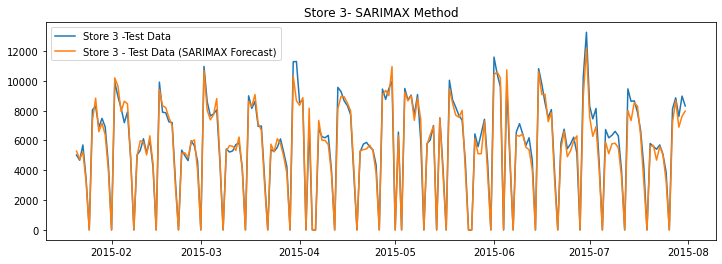

In [100]:
# Plotting test data and comparing with SARIMAX forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_3_sales['Sales'], label='Store 3 -Test Data')
plt.plot(y_hat_sarimax_store_3['Sarimax_Forecast_Sales'][test_store_3_sales.index.min():], label='Store 3 - Test Data (SARIMAX Forecast)')
plt.legend(loc='best')
plt.title('Store 3- SARIMAX Method')
plt.show()

In [101]:
# Calculating RMSE & MAPE values for Store 3
rmse = np.sqrt(mean_squared_error(test_store_3_sales['Sales'], y_hat_sarimax_store_3['Sarimax_Forecast_Sales'][test_store_3_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_3_sales['Sales']-y_hat_sarimax_store_3['Sarimax_Forecast_Sales'][test_store_3_sales.index.min():])/test_store_3_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 3', 'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store          Method        RMSE       MAPE
0   Store 1   SARIMA method     4624.91    4547.56
0   Store 3   SARIMA method   163984.79   40973.45
0   Store 8   SARIMA method    26705.61   16107.89
0   Store 9   SARIMA method    12834.35    7240.21
0  Store 13   SARIMA method     4944.74     100.00
0  Store 25   SARIMA method  3913891.97  720410.80
0  Store 29   SARIMA method   556344.15   89601.82
0  Store 31   SARIMA method    30375.75   15748.44
0  Store 46   SARIMA method     5173.41      87.74
0   Store 1  SARIMAX method      329.26       5.74
0   Store 3  SARIMAX method      555.14       6.67

##### Store 8

In [102]:
# Assigning Customers & Promo as exogeneous variable
exog_store_8 = store_8_sales[['Promo', 'Customers']]
train_exog_store_8 = exog_store_8[0 : train_len]
test_exog_store_8 = exog_store_8[train_len : ]

In [103]:
# SARIMAX model for Store 8
model = SARIMAX(train_store_8_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12), exog = train_exog_store_8) 
model_fit_8 = model.fit(maxiter = 1000)
print(model_fit_8.params)

Promo        0.114865
Customers    1.316027
ar.L1       -0.317194
ar.L2       -0.480679
ar.L3       -0.364702
ar.L4       -0.385018
ar.L5       -0.387623
ar.L6       -0.383056
ar.L7        0.610564
ar.L8       -0.064744
ar.L9        0.092967
ar.L10      -0.019186
ma.L1       -0.506811
ma.L2        0.058622
ma.L3       -0.048973
ma.L4        0.017153
ma.L5       -0.023979
ma.L6        0.005954
ma.L7       -0.959400
ma.L8        0.458125
ar.S.L12    -0.598939
ar.S.L24    -0.297791
sigma2       0.005061
dtype: float64


In [104]:
# Predicting Sales for Store 8
y_hat_sarimax_store_8 = store_8_Log_Sales.copy()
y_hat_sarimax_store_8['Sarimax_Forecast_Log_Sales'] = model_fit_8.predict(store_8_Log_Sales.index.min(),store_8_Log_Sales.index.max(), exog = test_exog_store_8)
y_hat_sarimax_store_8['Sarimax_Forecast_Sales'] = np.exp(y_hat_sarimax_store_8['Sarimax_Forecast_Log_Sales'])

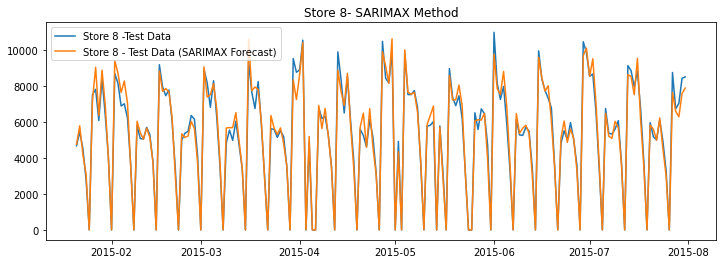

In [105]:
# Plotting test data and comparing with SARIMAX forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_8_sales['Sales'], label='Store 8 -Test Data')
plt.plot(y_hat_sarimax_store_8['Sarimax_Forecast_Sales'][test_store_8_sales.index.min():], label='Store 8 - Test Data (SARIMAX Forecast)')
plt.legend(loc='best')
plt.title('Store 8- SARIMAX Method')
plt.show()

In [106]:
# Calculating RMSE & MAPE values for Store 8
rmse = np.sqrt(mean_squared_error(test_store_8_sales['Sales'], y_hat_sarimax_store_8['Sarimax_Forecast_Sales'][test_store_8_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_8_sales['Sales']-y_hat_sarimax_store_8['Sarimax_Forecast_Sales'][test_store_8_sales.index.min():])/test_store_8_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 8', 'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store          Method        RMSE       MAPE
0   Store 1   SARIMA method     4624.91    4547.56
0   Store 3   SARIMA method   163984.79   40973.45
0   Store 8   SARIMA method    26705.61   16107.89
0   Store 9   SARIMA method    12834.35    7240.21
0  Store 13   SARIMA method     4944.74     100.00
0  Store 25   SARIMA method  3913891.97  720410.80
0  Store 29   SARIMA method   556344.15   89601.82
0  Store 31   SARIMA method    30375.75   15748.44
0  Store 46   SARIMA method     5173.41      87.74
0   Store 1  SARIMAX method      329.26       5.74
0   Store 3  SARIMAX method      555.14       6.67
0   Store 8  SARIMAX method      464.16       6.19

##### Store 9

In [107]:
# Assigning Customers & Promo as exogeneous variable
exog_store_9 = store_9_sales[['Promo', 'Customers']]
train_exog_store_9 = exog_store_9[0 : train_len]
test_exog_store_9 = exog_store_9[train_len : ]

In [108]:
# SARIMAX model for Store 9
model = SARIMAX(train_store_9_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12), exog = train_exog_store_9) 
model_fit_9 = model.fit(maxiter = 1000)
print(model_fit_9.params)

Promo        0.037858
Customers    1.377797
ar.L1       -1.942544
ar.L2       -2.224787
ar.L3       -2.495540
ar.L4       -2.314420
ar.L5       -1.940619
ar.L6       -1.575431
ar.L7       -0.641319
ar.L8       -0.025523
ar.L9       -0.149048
ar.L10      -0.070081
ma.L1        1.124981
ma.L2        0.536752
ma.L3        0.432587
ma.L4       -0.041636
ma.L5       -0.391652
ma.L6       -0.572261
ma.L7       -1.166207
ma.L8       -0.922551
ar.S.L12    -0.654661
ar.S.L24    -0.341279
sigma2       0.003240
dtype: float64


In [109]:
# Predicting Sales for Store 9
y_hat_sarimax_store_9 = store_9_Log_Sales.copy()
y_hat_sarimax_store_9['Sarimax_Forecast_Log_Sales'] = model_fit_9.predict(store_9_Log_Sales.index.min(),store_9_Log_Sales.index.max(), exog = test_exog_store_9)
y_hat_sarimax_store_9['Sarimax_Forecast_Sales'] = np.exp(y_hat_sarimax_store_9['Sarimax_Forecast_Log_Sales'])

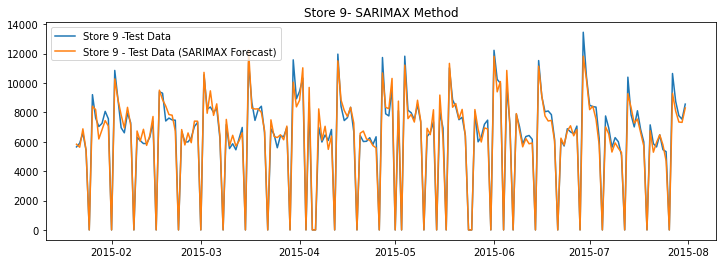

In [110]:
# Plotting test data and comparing with SARIMAX forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_9_sales['Sales'], label='Store 9 -Test Data')
plt.plot(y_hat_sarimax_store_9['Sarimax_Forecast_Sales'][test_store_9_sales.index.min():], label='Store 9 - Test Data (SARIMAX Forecast)')
plt.legend(loc='best')
plt.title('Store 9- SARIMAX Method')
plt.show()

In [111]:
# Calculating RMSE & MAPE values for Store 9
rmse = np.sqrt(mean_squared_error(test_store_9_sales['Sales'], y_hat_sarimax_store_9['Sarimax_Forecast_Sales'][test_store_9_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_9_sales['Sales']-y_hat_sarimax_store_9['Sarimax_Forecast_Sales'][test_store_9_sales.index.min():])/test_store_9_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 9', 'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

Store          Method        RMSE       MAPE
0   Store 1   SARIMA method     4624.91    4547.56
0   Store 3   SARIMA method   163984.79   40973.45
0   Store 8   SARIMA method    26705.61   16107.89
0   Store 9   SARIMA method    12834.35    7240.21
0  Store 13   SARIMA method     4944.74     100.00
0  Store 25   SARIMA method  3913891.97  720410.80
0  Store 29   SARIMA method   556344.15   89601.82
0  Store 31   SARIMA method    30375.75   15748.44
0  Store 46   SARIMA method     5173.41      87.74
0   Store 1  SARIMAX method      329.26       5.74
0   Store 3  SARIMAX method      555.14       6.67
0   Store 8  SARIMAX method      464.16       6.19
0   Store 9  SARIMAX method      481.69       4.99

##### Store 13

In [112]:
# Assigning Customers & Promo as exogeneous variable
exog_store_13 = store_13_sales[['Promo', 'Customers']]
exog_store_13 = exog_store_13.asfreq('D')
exog_store_13 = exog_store_13.fillna(0)
train_exog_store_13 = exog_store_13[0 : train_len]
test_exog_store_13 = exog_store_13[train_len : ]


In [113]:
# SARIMAX model for Store 13
model = SARIMAX(train_store_13_Log_Sales, order=(10, 1, 7), seasonal_order=(2, 1, 0, 12), exog = train_exog_store_13) 
model_fit_13 = model.fit(maxiter = 1000)
print(model_fit_13.params)

ValueError: The indices for endog and exog are not aligned

In [ ]:
# Predicting Sales for Store 13
y_hat_sarimax_store_13 = store_13_Log_Sales.copy()
y_hat_sarimax_store_13['Sarimax_Forecast_Log_Sales'] = model_fit_13.predict(store_13_Log_Sales.index.min(),store_13_Log_Sales.index.max(), exog = test_exog_store_13)
y_hat_sarimax_store_13['Sarimax_Forecast_Sales'] = np.exp(y_hat_sarimax_store_13['Sarimax_Forecast_Log_Sales'])

In [ ]:
# Plotting test data and comparing with SARIMAX forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_13_sales['Sales'], label='Store 13 -Test Data')
plt.plot(y_hat_sarimax_store_13['Sarimax_Forecast_Sales'][test_store_13_sales.index.min():], label='Store 13 - Test Data (SARIMAX Forecast)')
plt.legend(loc='best')
plt.title('Store 13- SARIMAX Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE values for Store 13
rmse = np.sqrt(mean_squared_error(test_store_13_sales['Sales'], y_hat_sarimax_store_13['Sarimax_Forecast_Sales'][test_store_13_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_13_sales['Sales']-y_hat_sarimax_store_13['Sarimax_Forecast_Sales'][test_store_13_sales.index.min():])/test_store_13_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 13', 'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 25

In [ ]:
# Assigning Customers & Promo as exogeneous variable
exog_store_25 = store_25_sales[['Promo', 'Customers']]
train_exog_store_25 = exog_store_25[0 : train_len]
test_exog_store_25 = exog_store_25[train_len : ]

In [ ]:
# SARIMAX model for Store 25
model = SARIMAX(train_store_25_Log_Sales, order=(8, 1, 8), seasonal_order=(2, 1, 0, 12), exog = train_exog_store_25) 
model_fit_25 = model.fit(maxiter = 1000)
print(model_fit_25.params)

In [ ]:
# Predicting Sales for Store 25
y_hat_sarimax_store_25 = store_25_Log_Sales.copy()
y_hat_sarimax_store_25['Sarimax_Forecast_Log_Sales'] = model_fit_25.predict(store_25_Log_Sales.index.min(),store_25_Log_Sales.index.max(), exog = test_exog_store_25)
y_hat_sarimax_store_25['Sarimax_Forecast_Sales'] = np.exp(y_hat_sarimax_store_25['Sarimax_Forecast_Log_Sales'])

In [ ]:
# Plotting test data and comparing with SARIMAX forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_25_sales['Sales'], label='Store 25 -Test Data')
plt.plot(y_hat_sarimax_store_25['Sarimax_Forecast_Sales'][test_store_25_sales.index.min():], label='Store 25 - Test Data (SARIMAX Forecast)')
plt.legend(loc='best')
plt.title('Store 25- SARIMAX Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE values for Store 25
rmse = np.sqrt(mean_squared_error(test_store_25_sales['Sales'], y_hat_sarimax_store_25['Sarimax_Forecast_Sales'][test_store_25_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_25_sales['Sales']-y_hat_sarimax_store_25['Sarimax_Forecast_Sales'][test_store_25_sales.index.min():])/test_store_25_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 25', 'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 29

In [ ]:
# Assigning Customers & Promo as exogeneous variable
exog_store_29 = store_29_sales[['Promo', 'Customers']]
train_exog_store_29 = exog_store_29[0 : train_len]
test_exog_store_29 = exog_store_29[train_len : ]

In [ ]:
# SARIMAX model for Store 29
model = SARIMAX(train_store_29_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12), exog = train_exog_store_29) 
model_fit_29 = model.fit(maxiter = 1000)
print(model_fit_29.params)

In [ ]:
# Predicting Sales for Store 29
y_hat_sarimax_store_29 = store_29_Log_Sales.copy()
y_hat_sarimax_store_29['Sarimax_Forecast_Log_Sales'] = model_fit_29.predict(store_29_Log_Sales.index.min(),store_29_Log_Sales.index.max(), exog = test_exog_store_29)
y_hat_sarimax_store_29['Sarimax_Forecast_Sales'] = np.exp(y_hat_sarimax_store_29['Sarimax_Forecast_Log_Sales'])

In [ ]:
# Plotting test data and comparing with SARIMAX forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_29_sales['Sales'], label='Store 29 -Test Data')
plt.plot(y_hat_sarimax_store_29['Sarimax_Forecast_Sales'][test_store_29_sales.index.min():], label='Store 29 - Test Data (SARIMAX Forecast)')
plt.legend(loc='best')
plt.title('Store 29- SARIMAX Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE values for Store 29
rmse = np.sqrt(mean_squared_error(test_store_29_sales['Sales'], y_hat_sarimax_store_29['Sarimax_Forecast_Sales'][test_store_29_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_29_sales['Sales']-y_hat_sarimax_store_29['Sarimax_Forecast_Sales'][test_store_29_sales.index.min():])/test_store_29_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 29', 'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 31

In [ ]:
# Assigning Customers & Promo as exogeneous variable
exog_store_31 = store_31_sales[['Promo', 'Customers']]
train_exog_store_31 = exog_store_31[0 : train_len]
test_exog_store_31 = exog_store_31[train_len : ]

In [ ]:
# SARIMAX model for Store 31
model = SARIMAX(train_store_31_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12), exog = train_exog_store_31) 
model_fit_31 = model.fit(maxiter = 1000)
print(model_fit_31.params)

In [ ]:
# Predicting Sales for Store 31
y_hat_sarimax_store_31 = store_31_Log_Sales.copy()
y_hat_sarimax_store_31['Sarimax_Forecast_Log_Sales'] = model_fit_31.predict(store_31_Log_Sales.index.min(),store_31_Log_Sales.index.max(), exog = test_exog_store_31)
y_hat_sarimax_store_31['Sarimax_Forecast_Sales'] = np.exp(y_hat_sarimax_store_31['Sarimax_Forecast_Log_Sales'])

In [ ]:
# Plotting test data and comparing with SARIMAX forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_31_sales['Sales'], label='Store 31 -Test Data')
plt.plot(y_hat_sarimax_store_31['Sarimax_Forecast_Sales'][test_store_31_sales.index.min():], label='Store 31 - Test Data (SARIMAX Forecast)')
plt.legend(loc='best')
plt.title('Store 31 - SARIMAX Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE values for Store 31
rmse = np.sqrt(mean_squared_error(test_store_31_sales['Sales'], y_hat_sarimax_store_31['Sarimax_Forecast_Sales'][test_store_31_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_31_sales['Sales']-y_hat_sarimax_store_31['Sarimax_Forecast_Sales'][test_store_31_sales.index.min():])/test_store_31_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 31', 'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 46

In [ ]:
# Assigning Customers & Promo as exogeneous variable
exog_store_46 = store_46_sales[['Promo', 'Customers']]
exog_store_46 = exog_store_46.asfreq('D')
exog_store_46 = exog_store_46.fillna(0)
train_exog_store_46 = exog_store_46[0 : train_len]
test_exog_store_46 = exog_store_46[train_len : ]

In [ ]:
# SARIMAX model for Store 46
model = SARIMAX(train_store_46_Log_Sales, order=(10, 1, 8), seasonal_order=(2, 1, 0, 12), exog = train_exog_store_46) 
model_fit_46 = model.fit(maxiter = 1000)
print(model_fit_46.params)

In [ ]:
# Predicting Sales for Store 46
y_hat_sarimax_store_46 = store_46_Log_Sales.copy()
y_hat_sarimax_store_46['Sarimax_Forecast_Log_Sales'] = model_fit_46.predict(store_46_Log_Sales.index.min(),store_46_Log_Sales.index.max(), exog = test_exog_store_46)
y_hat_sarimax_store_46['Sarimax_Forecast_Sales'] = np.exp(y_hat_sarimax_store_46['Sarimax_Forecast_Log_Sales'])

In [ ]:
# Plotting test data and comparing with SARIMAX forecasted value
plt.figure(figsize=(12,4))
#plt.plot(train_store_1_sales['Sales'], label='Train')
plt.plot(test_store_46_sales['Sales'], label='Store 46 -Test Data')
plt.plot(y_hat_sarimax_store_46['Sarimax_Forecast_Sales'][test_store_46_sales.index.min():], label='Store 46 - Test Data (SARIMAX Forecast)')
plt.legend(loc='best')
plt.title('Store 46- SARIMAX Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE values for Store 46
rmse = np.sqrt(mean_squared_error(test_store_46_sales['Sales'], y_hat_sarimax_store_46['Sarimax_Forecast_Sales'][test_store_46_sales.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_store_46_sales['Sales']-y_hat_sarimax_store_46['Sarimax_Forecast_Sales'][test_store_46_sales.index.min():])/test_store_46_sales['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 46', 'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

#### Holt Winter's Multiplicative Method with Trend and Seasonality Model Building

##### Store 1

In [ ]:
# Creating model for store 1
train_store_1_sales_hw = store_1_sales[0:train_len]
test_store_1_sales_hw = store_1_sales[train_len:]
y_hat_hwm_store_1 = test_store_1_sales_hw.copy()
model_hwm_1 = ExponentialSmoothing(np.asarray(train_store_1_sales['Sales']) ,seasonal_periods=12 ,trend='add', 
                                   seasonal='mul')
model_fit_hwm_1 = model_hwm_1.fit(optimized=True)
print(model_fit_hwm_1.params)
y_hat_hwm_store_1['HW_Forecast_Sales'] = model_fit_hwm_1.forecast(192)

In [ ]:
# Plotting train & Test data for Store 1
plt.figure(figsize=(12,4))
plt.plot(test_store_1_sales_hw['Sales'], label='Store 1 - Test Data')
plt.plot(y_hat_hwm_store_1['HW_Forecast_Sales'], label='Store 1 - Test Data (Holt\'s exponential smoothing forecast)')
plt.legend(loc='best')
plt.title('Store 1 - Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE for Store 1
rmse = np.sqrt(mean_squared_error(test_store_1_sales_hw['Sales'], y_hat_hwm_store_1['HW_Forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test_store_1_sales_hw['Sales']-y_hat_hwm_store_1['HW_Forecast_Sales'])/test_store_1_sales_hw['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 1', 'Method':['HW Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 3

In [ ]:
# Creating model for store 3
train_store_3_sales_hw = store_3_sales[0:train_len]
test_store_3_sales_hw = store_3_sales[train_len:]
y_hat_hwm_store_3 = test_store_3_sales_hw.copy()
model_hwm_3 = ExponentialSmoothing(np.asarray(train_store_3_sales['Sales']) ,seasonal_periods=12 ,trend='add', 
                                   seasonal='mul')
model_fit_hwm_3 = model_hwm_3.fit(optimized=True)
print(model_fit_hwm_3.params)
y_hat_hwm_store_3['HW_Forecast_Sales'] = model_fit_hwm_3.forecast(192)

In [ ]:
# Plotting train & Test data for Store 3
plt.figure(figsize=(12,4))
plt.plot(test_store_3_sales_hw['Sales'], label='Store 3 - Test Data')
plt.plot(y_hat_hwm_store_3['HW_Forecast_Sales'], label='Store 3 - Test Data (Holt\'s exponential smoothing forecast)')
plt.legend(loc='best')
plt.title('Store 3 - Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE for Store 3
rmse = np.sqrt(mean_squared_error(test_store_3_sales_hw['Sales'], y_hat_hwm_store_3['HW_Forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test_store_3_sales_hw['Sales']-y_hat_hwm_store_3['HW_Forecast_Sales'])/test_store_3_sales_hw['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 3', 'Method':['HW Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 8

In [ ]:
# Creating model for store 8
train_store_8_sales_hw = store_8_sales[0:train_len]
test_store_8_sales_hw = store_8_sales[train_len:]
y_hat_hwm_store_8 = test_store_8_sales_hw.copy()
model_hwm_8 = ExponentialSmoothing(np.asarray(train_store_8_sales['Sales']) ,seasonal_periods=12 ,trend='add', 
                                   seasonal='mul')
model_fit_hwm_8 = model_hwm_8.fit(optimized=True)
print(model_fit_hwm_8.params)
y_hat_hwm_store_8['HW_Forecast_Sales'] = model_fit_hwm_8.forecast(192)

In [ ]:
# Plotting train & Test data for Store 8
plt.figure(figsize=(12,4))
plt.plot(test_store_8_sales_hw['Sales'], label='Store 8 - Test Data')
plt.plot(y_hat_hwm_store_8['HW_Forecast_Sales'], label='Store 8 - Test Data (Holt\'s exponential smoothing forecast)')
plt.legend(loc='best')
plt.title('Store 8 - Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE for Store 8
rmse = np.sqrt(mean_squared_error(test_store_8_sales_hw['Sales'], y_hat_hwm_store_8['HW_Forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test_store_8_sales_hw['Sales']-y_hat_hwm_store_8['HW_Forecast_Sales'])/test_store_8_sales_hw['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 8', 'Method':['HW Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 9

In [ ]:
# Creating model for store 9
train_store_9_sales_hw = store_9_sales[0:train_len]
test_store_9_sales_hw = store_9_sales[train_len:]
y_hat_hwm_store_9 = test_store_9_sales_hw.copy()
model_hwm_9 = ExponentialSmoothing(np.asarray(train_store_9_sales['Sales']) ,seasonal_periods=12 ,trend='add', 
                                   seasonal='mul')
model_fit_hwm_9 = model_hwm_9.fit(optimized=True)
print(model_fit_hwm_9.params)
y_hat_hwm_store_9['HW_Forecast_Sales'] = model_fit_hwm_9.forecast(192)

In [ ]:
# Plotting train & Test data for Store 9
plt.figure(figsize=(12,4))
plt.plot(test_store_9_sales_hw['Sales'], label='Store 9 - Test Data')
plt.plot(y_hat_hwm_store_9['HW_Forecast_Sales'], label='Store 9 - Test Data (Holt\'s exponential smoothing forecast)')
plt.legend(loc='best')
plt.title('Store 9 - Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE for Store 9
rmse = np.sqrt(mean_squared_error(test_store_9_sales_hw['Sales'], y_hat_hwm_store_9['HW_Forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test_store_9_sales_hw['Sales']-y_hat_hwm_store_9['HW_Forecast_Sales'])/test_store_9_sales_hw['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 9', 'Method':['HW Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 13

In [ ]:
# Creating model for store 13
train_store_13_sales_hw = store_13_sales[0 : 600]
test_store_13_sales_hw = store_13_sales[600:]
y_hat_hwm_store_13 = test_store_13_sales_hw.copy()
model_hwm_13 = ExponentialSmoothing(np.asarray(train_store_13_sales['Sales']) ,seasonal_periods=12 ,trend='add', 
                                   seasonal='mul')
model_fit_hwm_13 = model_hwm_13.fit(optimized=True)
print(model_fit_hwm_13.params)
y_hat_hwm_store_13['HW_Forecast_Sales'] = model_fit_hwm_13.forecast(158)

In [ ]:
# Plotting train & Test data for Store 13
plt.figure(figsize=(12,4))
plt.plot(test_store_13_sales_hw['Sales'], label='Store 13 - Test Data')
plt.plot(y_hat_hwm_store_13['HW_Forecast_Sales'], label='Store 13 - Test Data (Holt\'s exponential smoothing forecast)')
plt.legend(loc='best')
plt.title('Store 13 - Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE for Store 13
rmse = np.sqrt(mean_squared_error(test_store_13_sales_hw['Sales'], y_hat_hwm_store_13['HW_Forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test_store_13_sales_hw['Sales']-y_hat_hwm_store_13['HW_Forecast_Sales'])/test_store_13_sales_hw['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 13', 'Method':['HW Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 25

In [ ]:
# Creating model for store 25
train_store_25_sales_hw = store_25_sales[0:train_len]
test_store_25_sales_hw = store_25_sales[train_len:]
y_hat_hwm_store_25 = test_store_25_sales_hw.copy()
model_hwm_25 = ExponentialSmoothing(np.asarray(train_store_25_sales['Sales']) ,seasonal_periods=12 ,trend='add', 
                                   seasonal='mul')
model_fit_hwm_25 = model_hwm_25.fit(optimized=True)
print(model_fit_hwm_25.params)
y_hat_hwm_store_25['HW_Forecast_Sales'] = model_fit_hwm_25.forecast(192)

In [ ]:
# Plotting train & Test data for Store 25
plt.figure(figsize=(12,4))
plt.plot(test_store_25_sales_hw['Sales'], label='Store 25 - Test Data')
plt.plot(y_hat_hwm_store_25['HW_Forecast_Sales'], label='Store 25 - Test Data (Holt\'s exponential smoothing forecast)')
plt.legend(loc='best')
plt.title('Store 25 - Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE for Store 25
rmse = np.sqrt(mean_squared_error(test_store_25_sales_hw['Sales'], y_hat_hwm_store_25['HW_Forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test_store_25_sales_hw['Sales']-y_hat_hwm_store_25['HW_Forecast_Sales'])/test_store_25_sales_hw['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 25', 'Method':['HW Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 29

In [ ]:
# Creating model for store 29
train_store_29_sales_hw = store_29_sales[0:train_len]
test_store_29_sales_hw = store_29_sales[train_len:]
y_hat_hwm_store_29 = test_store_29_sales_hw.copy()
model_hwm_29 = ExponentialSmoothing(np.asarray(train_store_29_sales['Sales']) ,seasonal_periods=12 ,trend='add', 
                                   seasonal='mul')
model_fit_hwm_29 = model_hwm_29.fit(optimized=True)
print(model_fit_hwm_29.params)
y_hat_hwm_store_29['HW_Forecast_Sales'] = model_fit_hwm_29.forecast(192)

In [ ]:
# Plotting train & Test data for Store 29
plt.figure(figsize=(12,4))
plt.plot(test_store_29_sales_hw['Sales'], label='Store 29 - Test Data')
plt.plot(y_hat_hwm_store_29['HW_Forecast_Sales'], label='Store 29 - Test Data (Holt\'s exponential smoothing forecast)')
plt.legend(loc='best')
plt.title('Store 29 - Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE for Store 29
rmse = np.sqrt(mean_squared_error(test_store_29_sales_hw['Sales'], y_hat_hwm_store_29['HW_Forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test_store_29_sales_hw['Sales']-y_hat_hwm_store_29['HW_Forecast_Sales'])/test_store_29_sales_hw['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 29', 'Method':['HW Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 31

In [ ]:
# Creating model for store 31
train_store_31_sales_hw = store_31_sales[0:train_len]
test_store_31_sales_hw = store_31_sales[train_len:]
y_hat_hwm_store_31 = test_store_31_sales_hw.copy()
model_hwm_31 = ExponentialSmoothing(np.asarray(train_store_31_sales['Sales']) ,seasonal_periods=12 ,trend='add', 
                                   seasonal='mul')
model_fit_hwm_31 = model_hwm_31.fit(optimized=True)
print(model_fit_hwm_31.params)
y_hat_hwm_store_31['HW_Forecast_Sales'] = model_fit_hwm_31.forecast(192)

In [ ]:
# Plotting train & Test data for Store 31
plt.figure(figsize=(12,4))
plt.plot(test_store_31_sales_hw['Sales'], label='Store 31 - Test Data')
plt.plot(y_hat_hwm_store_31['HW_Forecast_Sales'], label='Store 31 - Test Data (Holt\'s exponential smoothing forecast)')
plt.legend(loc='best')
plt.title('Store 31 - Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE for Store 31
rmse = np.sqrt(mean_squared_error(test_store_31_sales_hw['Sales'], y_hat_hwm_store_31['HW_Forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test_store_31_sales_hw['Sales']-y_hat_hwm_store_31['HW_Forecast_Sales'])/test_store_31_sales_hw['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 31', 'Method':['HW Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

##### Store 46

In [ ]:
# Creating model for store 46
train_store_46_sales_hw = store_46_sales[0:600]
test_store_46_sales_hw = store_46_sales[600:]
y_hat_hwm_store_46 = test_store_46_sales_hw.copy()
model_hwm_46 = ExponentialSmoothing(np.asarray(train_store_46_sales['Sales']) ,seasonal_periods=12 ,trend='add', 
                                   seasonal='mul')
model_fit_hwm_46 = model_hwm_46.fit(optimized=True)
print(model_fit_hwm_46.params)
y_hat_hwm_store_46['HW_Forecast_Sales'] = model_fit_hwm_46.forecast(158)

In [ ]:
# Plotting train & Test data for Store 46
plt.figure(figsize=(12,4))
plt.plot(test_store_46_sales_hw['Sales'], label='Store 46 - Test Data')
plt.plot(y_hat_hwm_store_46['HW_Forecast_Sales'], label='Store 46 - Test Data (Holt\'s exponential smoothing forecast)')
plt.legend(loc='best')
plt.title('Store 46 - Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculating RMSE & MAPE for Store 46
rmse = np.sqrt(mean_squared_error(test_store_46_sales_hw['Sales'], y_hat_hwm_store_46['HW_Forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test_store_46_sales_hw['Sales']-y_hat_hwm_store_46['HW_Forecast_Sales'])/test_store_46_sales_hw['Sales'])*100,2)

tempResults = pd.DataFrame({'Store' : 'Store 46', 'Method':['HW Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Store', 'Method', 'RMSE', 'MAPE']]
results

SARIMAX model is giving the best results, in comparison to SARIMA & Holt's Winter Multiplicative method.

However, since we do not have any information on promotion or customers for next 6 weeks we will use SARIMA model to predict the Sales for next 6 weeks

#### Forecasts for next 6 weeks

##### Store 1

In [ ]:
# End date for all stores
end_date = store_1_sales.index.max()
sixweeks = datetime.timedelta(weeks =6)
predicted_end_date = end_date + sixweeks
print('End date of each store: ', end_date)
print('End Date for Forecasting : ', predicted_end_date)

In [ ]:
# Creating datetime for next six weeks for forecasting
predicted_sixweeks_daterange = pd.date_range(start = '2015-8-01', end = '2015-09-11', freq = 'D')
predicted_sixweeks_daterange

In [ ]:
# Forecasting Sales for Store 1
y_hat_sarima_store_1_forecast = pd.DataFrame()
y_hat_sarima_store_1_forecast['Sarima_Forecast_Log_Sales_6w'] = model_fit_1sa.predict(predicted_sixweeks_daterange.min(),predicted_sixweeks_daterange.max())
y_hat_sarima_store_1_forecast['Sarima_Forecast_Sales_6w'] = np.exp(y_hat_sarima_store_1_forecast['Sarima_Forecast_Log_Sales_6w'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_1_sales['Sales'], label='Store 1 -Test Data')
plt.plot(y_hat_sarima_store_1['Sarima_Forecast_Sales'][test_store_1_sales.index.min():], label='Store 1 - Test Data (SARIMA Forecast)')
plt.plot(y_hat_sarima_store_1_forecast['Sarima_Forecast_Sales_6w'][predicted_sixweeks_daterange.min():], label='Store 1 - Forecast 6 Weeks')
plt.legend(loc='best')
plt.title('Store 1- Forecast For Next 6 Weeks')
plt.show()

##### Store 3

In [ ]:
# Forecasting Sales
y_hat_sarima_store_3_forecast = pd.DataFrame()
y_hat_sarima_store_3_forecast['Sarima_Forecast_Log_Sales_6w'] = model_fit_3sa.predict(predicted_sixweeks_daterange.min(),predicted_sixweeks_daterange.max())
y_hat_sarima_store_3_forecast['Sarima_Forecast_Sales_6w'] = np.exp(y_hat_sarima_store_3_forecast['Sarima_Forecast_Log_Sales_6w'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_3_sales['Sales'], label='Store 3 -Test Data')
plt.plot(y_hat_sarima_store_3['Sarima_Forecast_Sales'][test_store_3_sales.index.min():], label='Store 3 - Test Data (SARIMA Forecast)')
plt.plot(y_hat_sarima_store_3_forecast['Sarima_Forecast_Sales_6w'][predicted_sixweeks_daterange.min():], label='Store 3 - Forecast 6 Weeks')
plt.legend(loc='best')
plt.title('Store 3- Forecast For Next 6 Weeks')
plt.show()

##### Store 8

In [ ]:
# Forecasting Sales
y_hat_sarima_store_8_forecast = pd.DataFrame()
y_hat_sarima_store_8_forecast['Sarima_Forecast_Log_Sales_6w'] = model_fit_8sa.predict(predicted_sixweeks_daterange.min(),predicted_sixweeks_daterange.max())
y_hat_sarima_store_8_forecast['Sarima_Forecast_Sales_6w'] = np.exp(y_hat_sarima_store_8_forecast['Sarima_Forecast_Log_Sales_6w'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_8_sales['Sales'], label='Store 8 -Test Data')
plt.plot(y_hat_sarima_store_8['Sarima_Forecast_Sales'][test_store_8_sales.index.min():], label='Store 8 - Test Data (SARIMA Forecast)')
plt.plot(y_hat_sarima_store_8_forecast['Sarima_Forecast_Sales_6w'][predicted_sixweeks_daterange.min():], label='Store 8 - Forecast 6 Weeks')
plt.legend(loc='best')
plt.title('Store 8- Forecast For Next 6 Weeks')
plt.show()

##### Store 9

In [ ]:
# Forecasting Sales
y_hat_sarima_store_9_forecast = pd.DataFrame()
y_hat_sarima_store_9_forecast['Sarima_Forecast_Log_Sales_6w'] = model_fit_9sa.predict(predicted_sixweeks_daterange.min(),predicted_sixweeks_daterange.max())
y_hat_sarima_store_9_forecast['Sarima_Forecast_Sales_6w'] = np.exp(y_hat_sarima_store_9_forecast['Sarima_Forecast_Log_Sales_6w'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_9_sales['Sales'], label='Store 9 -Test Data')
plt.plot(y_hat_sarima_store_9['Sarima_Forecast_Sales'][test_store_9_sales.index.min():], label='Store 9 - Test Data (SARIMA Forecast)')
plt.plot(y_hat_sarima_store_9_forecast['Sarima_Forecast_Sales_6w'][predicted_sixweeks_daterange.min():], label='Store 9 - Forecast 6 Weeks')
plt.legend(loc='best')
plt.title('Store 9- Forecast For Next 6 Weeks')
plt.show()

##### Store 13

In [ ]:
# Forecasting Sales
y_hat_sarima_store_13_forecast = pd.DataFrame()
y_hat_sarima_store_13_forecast['Sarima_Forecast_Log_Sales_6w'] = model_fit_13sa.predict(predicted_sixweeks_daterange.min(),predicted_sixweeks_daterange.max())
y_hat_sarima_store_13_forecast['Sarima_Forecast_Sales_6w'] = np.exp(y_hat_sarima_store_13_forecast['Sarima_Forecast_Log_Sales_6w'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_13_sales['Sales'], label='Store 13 -Test Data')
plt.plot(y_hat_sarima_store_13['Sarima_Forecast_Sales'][test_store_13_sales.index.min():], label='Store 13 - Test Data (SARIMA Forecast)')
plt.plot(y_hat_sarima_store_13_forecast['Sarima_Forecast_Sales_6w'][predicted_sixweeks_daterange.min():], label='Store 13 - Forecast 6 Weeks')
plt.legend(loc='best')
plt.title('Store 13- Forecast For Next 6 Weeks')
plt.show()

##### Store 25

In [ ]:
# Forecasting Sales
y_hat_sarima_store_25_forecast = pd.DataFrame()
y_hat_sarima_store_25_forecast['Sarima_Forecast_Log_Sales_6w'] = model_fit_25sa.predict(predicted_sixweeks_daterange.min(),predicted_sixweeks_daterange.max())
y_hat_sarima_store_25_forecast['Sarima_Forecast_Sales_6w'] = np.exp(y_hat_sarima_store_25_forecast['Sarima_Forecast_Log_Sales_6w'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_25_sales['Sales'], label='Store 25 -Test Data')
plt.plot(y_hat_sarima_store_25['Sarima_Forecast_Sales'][test_store_25_sales.index.min():], label='Store 25 - Test Data (SARIMA Forecast)')
plt.plot(y_hat_sarima_store_25_forecast['Sarima_Forecast_Sales_6w'][predicted_sixweeks_daterange.min():], label='Store 25 - Forecast 6 Weeks')
plt.legend(loc='best')
plt.title('Store 25- Forecast For Next 6 Weeks')
plt.show()

##### Store 29

In [ ]:
# Forecasting Sales
y_hat_sarima_store_29_forecast = pd.DataFrame()
y_hat_sarima_store_29_forecast['Sarima_Forecast_Log_Sales_6w'] = model_fit_29sa.predict(predicted_sixweeks_daterange.min(),predicted_sixweeks_daterange.max())
y_hat_sarima_store_29_forecast['Sarima_Forecast_Sales_6w'] = np.exp(y_hat_sarima_store_29_forecast['Sarima_Forecast_Log_Sales_6w'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_29_sales['Sales'], label='Store 29 -Test Data')
plt.plot(y_hat_sarima_store_29['Sarima_Forecast_Sales'][test_store_29_sales.index.min():], label='Store 29 - Test Data (SARIMA Forecast)')
plt.plot(y_hat_sarima_store_29_forecast['Sarima_Forecast_Sales_6w'][predicted_sixweeks_daterange.min():], label='Store 29 - Forecast 6 Weeks')
plt.legend(loc='best')
plt.title('Store 29- Forecast For Next 6 Weeks')
plt.show()

##### Store 31

In [ ]:
# Forecasting Sales
y_hat_sarima_store_31_forecast = pd.DataFrame()
y_hat_sarima_store_31_forecast['Sarima_Forecast_Log_Sales_6w'] = model_fit_31sa.predict(predicted_sixweeks_daterange.min(),predicted_sixweeks_daterange.max())
y_hat_sarima_store_31_forecast['Sarima_Forecast_Sales_6w'] = np.exp(y_hat_sarima_store_31_forecast['Sarima_Forecast_Log_Sales_6w'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_31_sales['Sales'], label='Store 31 -Test Data')
plt.plot(y_hat_sarima_store_31['Sarima_Forecast_Sales'][test_store_31_sales.index.min():], label='Store 31 - Test Data (SARIMA Forecast)')
plt.plot(y_hat_sarima_store_31_forecast['Sarima_Forecast_Sales_6w'][predicted_sixweeks_daterange.min():], label='Store 31 - Forecast 6 Weeks')
plt.legend(loc='best')
plt.title('Store 31- Forecast For Next 6 Weeks')
plt.show()

##### Store 46

In [ ]:
# Forecasting Sales
y_hat_sarima_store_46_forecast = pd.DataFrame()
y_hat_sarima_store_46_forecast['Sarima_Forecast_Log_Sales_6w'] = model_fit_46sa.predict(predicted_sixweeks_daterange.min(),predicted_sixweeks_daterange.max())
y_hat_sarima_store_46_forecast['Sarima_Forecast_Sales_6w'] = np.exp(y_hat_sarima_store_46_forecast['Sarima_Forecast_Log_Sales_6w'])

# Plotting test data and comparing with SARIMA forecasted value
plt.figure(figsize=(12,4))
plt.plot(test_store_46_sales['Sales'], label='Store 46 -Test Data')
plt.plot(y_hat_sarima_store_46['Sarima_Forecast_Sales'][test_store_46_sales.index.min():], label='Store 46 - Test Data (SARIMA Forecast)')
plt.plot(y_hat_sarima_store_46_forecast['Sarima_Forecast_Sales_6w'][predicted_sixweeks_daterange.min():], label='Store 46 - Forecast 6 Weeks')
plt.legend(loc='best')
plt.title('Store 46- Forecast For Next 6 Weeks')
plt.show()